<a href="https://colab.research.google.com/github/PriyanshuR23/Industrial_IOT_Predictive_Maintenance/blob/main/IIOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor,  DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor, VotingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [38]:
# Load dataset
#file_path = '/content/sensor.csv' #local
file_path = "https://media.githubusercontent.com/media/somjit101/Predictive-Maintenance-Industrial-IOT/refs/heads/main/sensor.csv"
sensor_data = pd.read_csv(file_path)


In [39]:


# Convert Timestamp Column
sensor_data['timestamp'] = pd.to_datetime(sensor_data.iloc[:, 53], format='%d-%m-%y %H:%M')


In [40]:
# Data Overview
print("Dataset Summary:")
print(sensor_data.info())
print("\nMissing Values:")
print(sensor_data.isnull().sum())


Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220313 entries, 0 to 220312
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   ID              220313 non-null  int64         
 1   sensor_00       210105 non-null  float64       
 2   sensor_01       219944 non-null  float64       
 3   sensor_02       220294 non-null  float64       
 4   sensor_03       220294 non-null  float64       
 5   sensor_04       220294 non-null  float64       
 6   sensor_05       220294 non-null  float64       
 7   sensor_06       215515 non-null  float64       
 8   sensor_07       214862 non-null  float64       
 9   sensor_08       215206 non-null  float64       
 10  sensor_09       215718 non-null  float64       
 11  sensor_10       220294 non-null  float64       
 12  sensor_11       220294 non-null  float64       
 13  sensor_12       220294 non-null  float64       
 14  sensor_13       220

In [41]:
# Handling Missing Values
sensor_data.iloc[:, 1:52] = sensor_data.iloc[:, 1:52].fillna(sensor_data.iloc[:, 1:52].median())
sensor_data = sensor_data.dropna(subset=['machine_status'])

In [42]:
print(sensor_data.isnull().sum())

ID                0
sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_15         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0
sensor_48         0


In [43]:
# Variance Analysis for Feature Selection
variances = sensor_data.iloc[:, 1:52].var().sort_values(ascending=False)
selected_sensors = variances[variances > 0.01].index.tolist()
selected_sensors.append('machine_status')

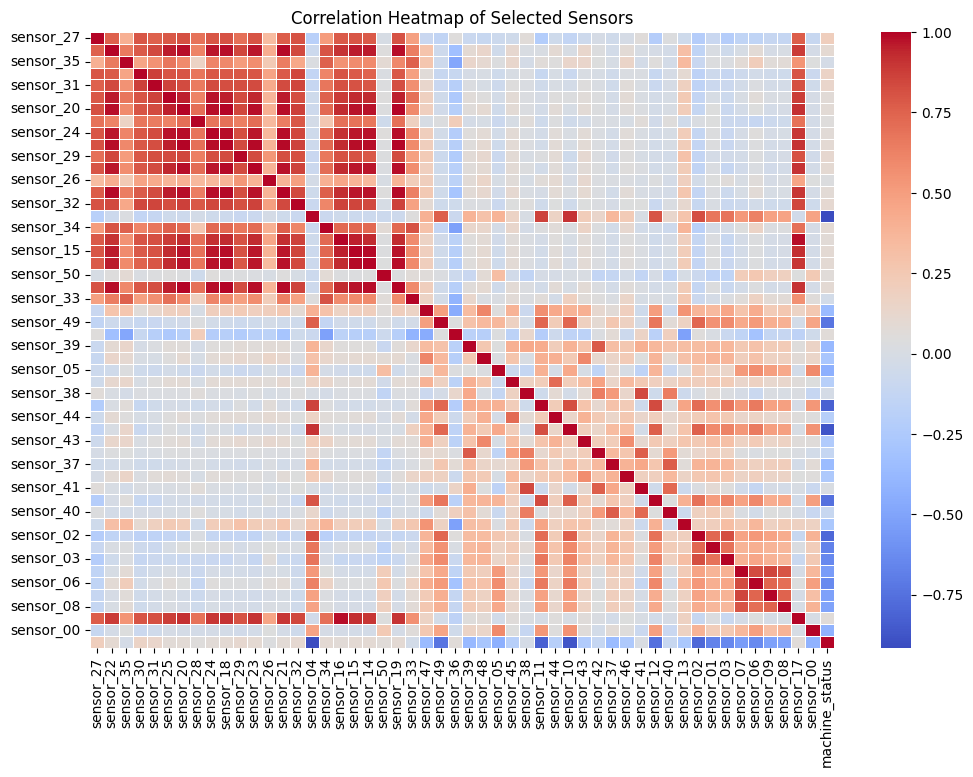

In [44]:
# Correlation Analysis
# Include all relevant columns for correlation analysis
correlation_matrix = sensor_data[selected_sensors].corr()  # Selecting all necessary columns including 'machine_status'
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Selected Sensors')
plt.show()


In [45]:
# PCA for Dimensionality Reduction
scaler = StandardScaler()
sensor_scaled = scaler.fit_transform(sensor_data[selected_sensors])
pca = PCA(n_components=5)
pca_result = pca.fit_transform(sensor_scaled)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.3363595  0.20317066 0.08309224 0.05434472 0.0428538 ]


In [46]:
# Descriptive Statistics
print("\nDescriptive Statistics of Selected Sensors:")
print(sensor_data[selected_sensors].describe())


Descriptive Statistics of Selected Sensors:
           sensor_27      sensor_22      sensor_35      sensor_30  \
count  220313.000000  220313.000000  220313.000000  220313.000000   
mean      851.694935     922.614918     593.047258     863.324712   
std       313.064039     291.823915     289.378000     283.537778   
min         4.319347       0.000000       2.260970      23.958330   
25%       782.685500     950.922800     288.559000     839.062400   
50%       967.270800     981.925000     709.673500     917.708300   
75%      1043.966000    1090.807000     837.330400     981.249900   
max      1841.146000    1227.564000     984.060700    1800.000000   

           sensor_31      sensor_25      sensor_20      sensor_28  \
count  220313.000000  220313.000000  220313.000000  220313.000000   
mean      804.306615     786.419528     796.232686     576.190498   
std       260.567725     246.653011     226.671323     225.727245   
min         0.240716      43.154790      95.527660       

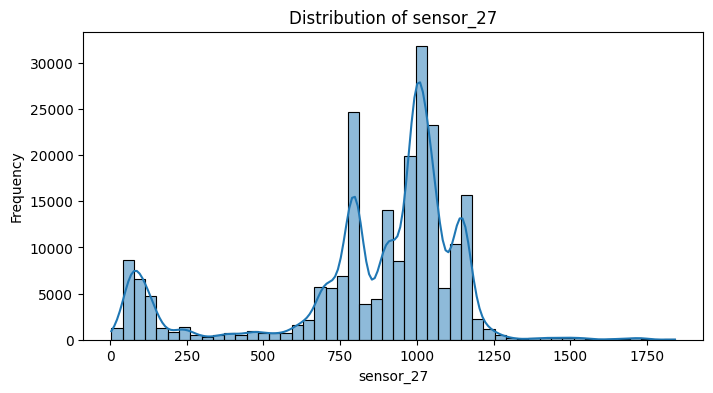

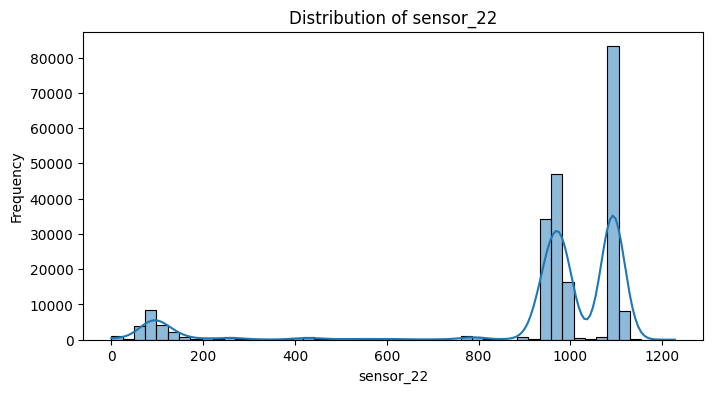

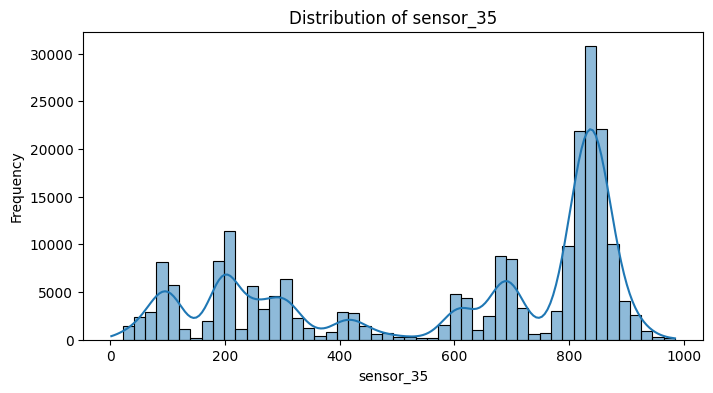

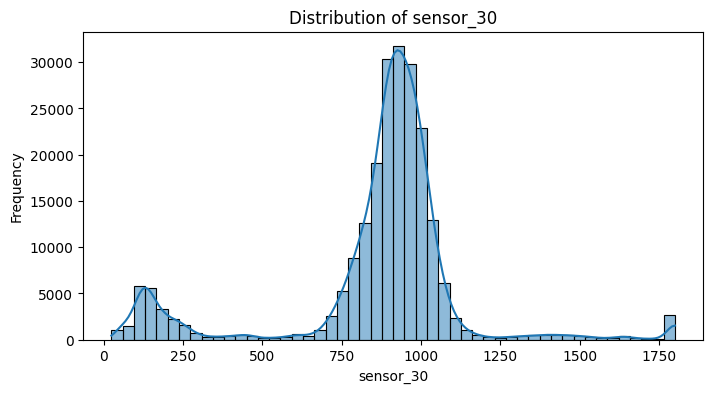

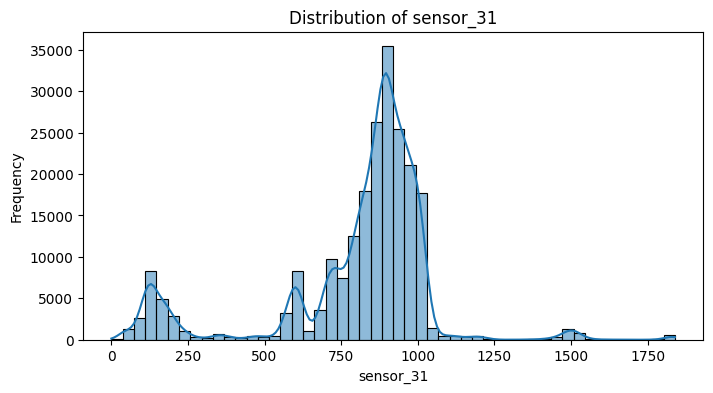

In [47]:
# Visualizations
for sensor in selected_sensors[:5]:  # Limit to 5 sensors for clarity
    plt.figure(figsize=(8,4))
    sns.histplot(sensor_data[sensor], bins=50, kde=True)
    plt.title(f'Distribution of {sensor}')
    plt.xlabel(sensor)
    plt.ylabel('Frequency')
    plt.show()

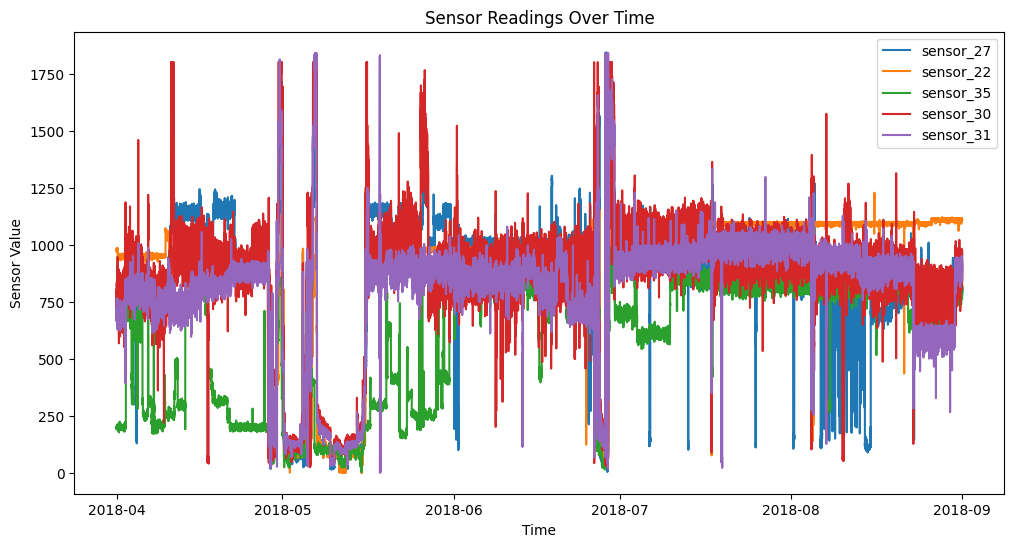

In [48]:
# Time-Series Plot
plt.figure(figsize=(12,6))
for sensor in selected_sensors[:5]:
    plt.plot(sensor_data['timestamp'], sensor_data[sensor], label=sensor)
plt.title('Sensor Readings Over Time')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()
plt.show()

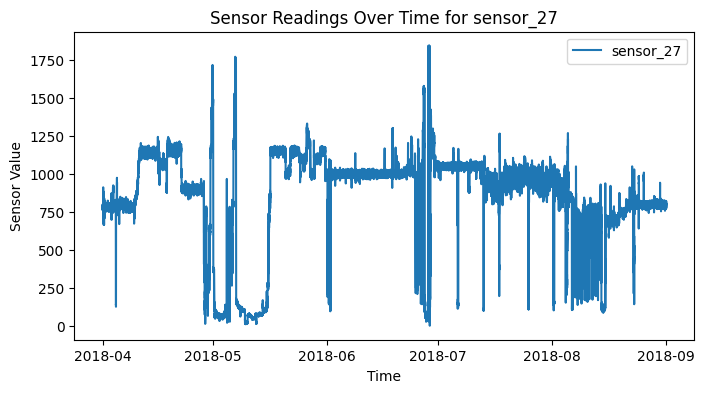

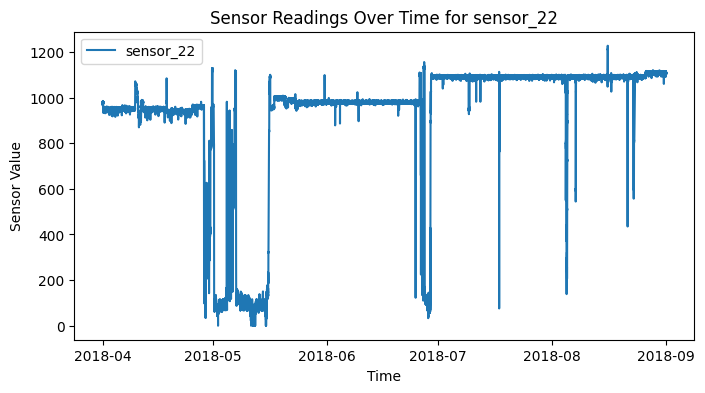

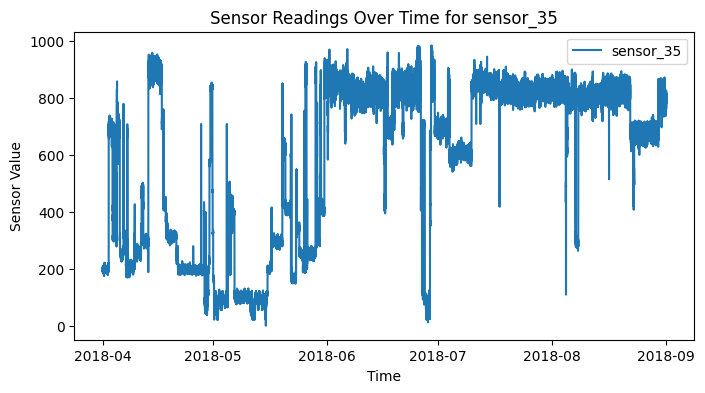

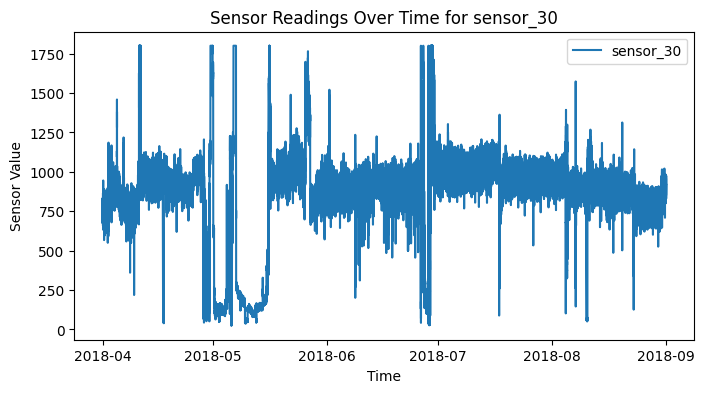

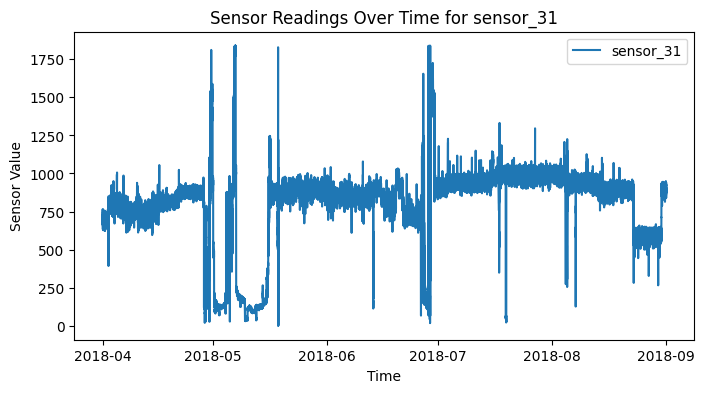

In [49]:
# Time-Series Plots for Individual Sensors
for sensor in selected_sensors[:5]:  # Limit to 5 sensors for clarity
    plt.figure(figsize=(8, 4))  # Create a new figure for each sensor
    plt.plot(sensor_data['timestamp'], sensor_data[sensor], label=sensor)
    plt.title(f'Sensor Readings Over Time for {sensor}')
    plt.xlabel('Time')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.show()

In [50]:
#Feature Engineering
# Find absolute correlations with target variable (e.g., machine_status)
target = 'machine_status'  # Update based on actual failure column
correlations = correlation_matrix[target].abs().sort_values(ascending=False)
# print(correlations)

# Select top features (excluding the target itself)
important_features = correlations[correlations >= 0.5].index.tolist()
print("Selected Features:", important_features)

Selected Features: ['machine_status', 'sensor_04', 'sensor_10', 'sensor_11', 'sensor_02', 'sensor_12', 'sensor_49', 'sensor_01', 'sensor_03', 'sensor_06', 'sensor_07', 'sensor_09', 'sensor_08']


In [51]:
important_features.remove('machine_status')

In [52]:
print("Selected Features:", important_features)
len(important_features)

Selected Features: ['sensor_04', 'sensor_10', 'sensor_11', 'sensor_02', 'sensor_12', 'sensor_49', 'sensor_01', 'sensor_03', 'sensor_06', 'sensor_07', 'sensor_09', 'sensor_08']


12

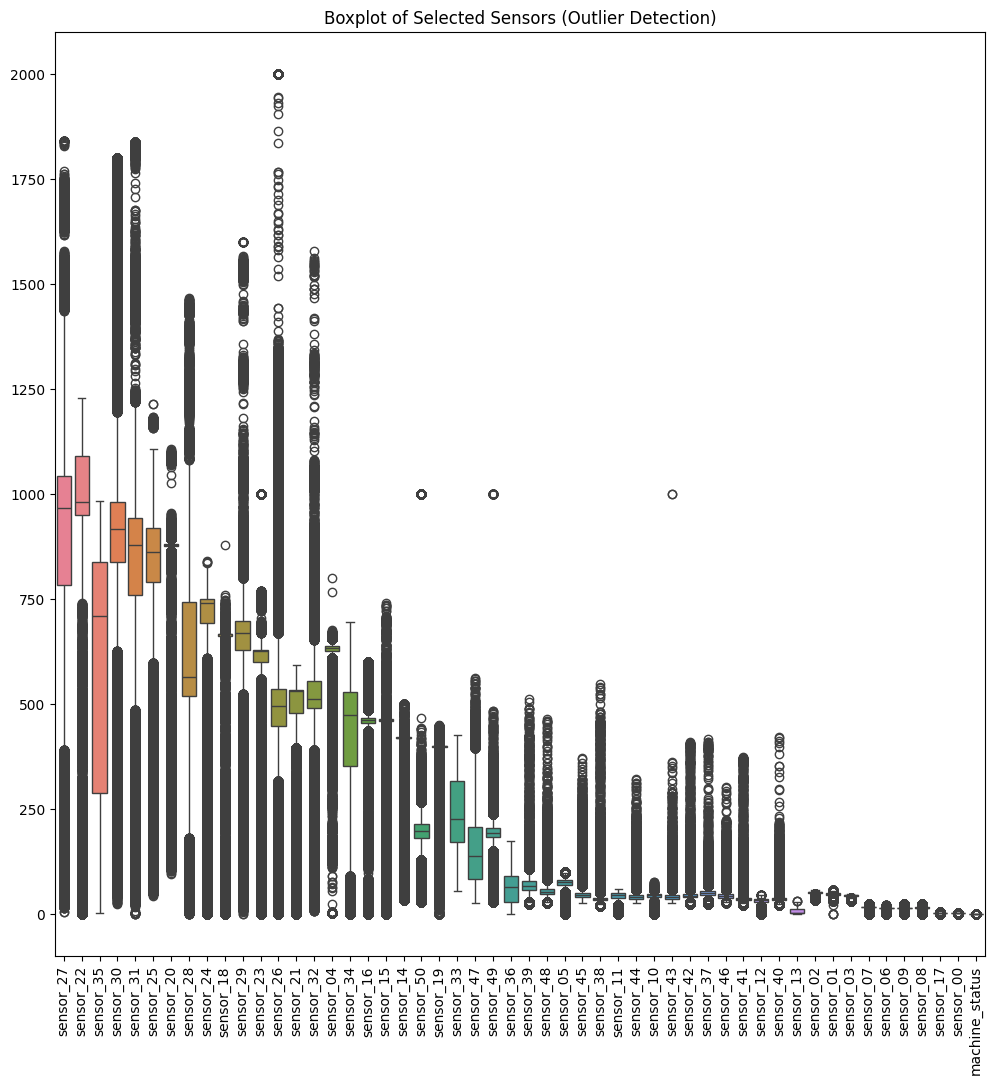

In [53]:
plt.figure(figsize=(12, 12))
sns.boxplot(data=sensor_data[selected_sensors])
plt.xticks(rotation=90)
plt.title("Boxplot of Selected Sensors (Outlier Detection)")
plt.show()

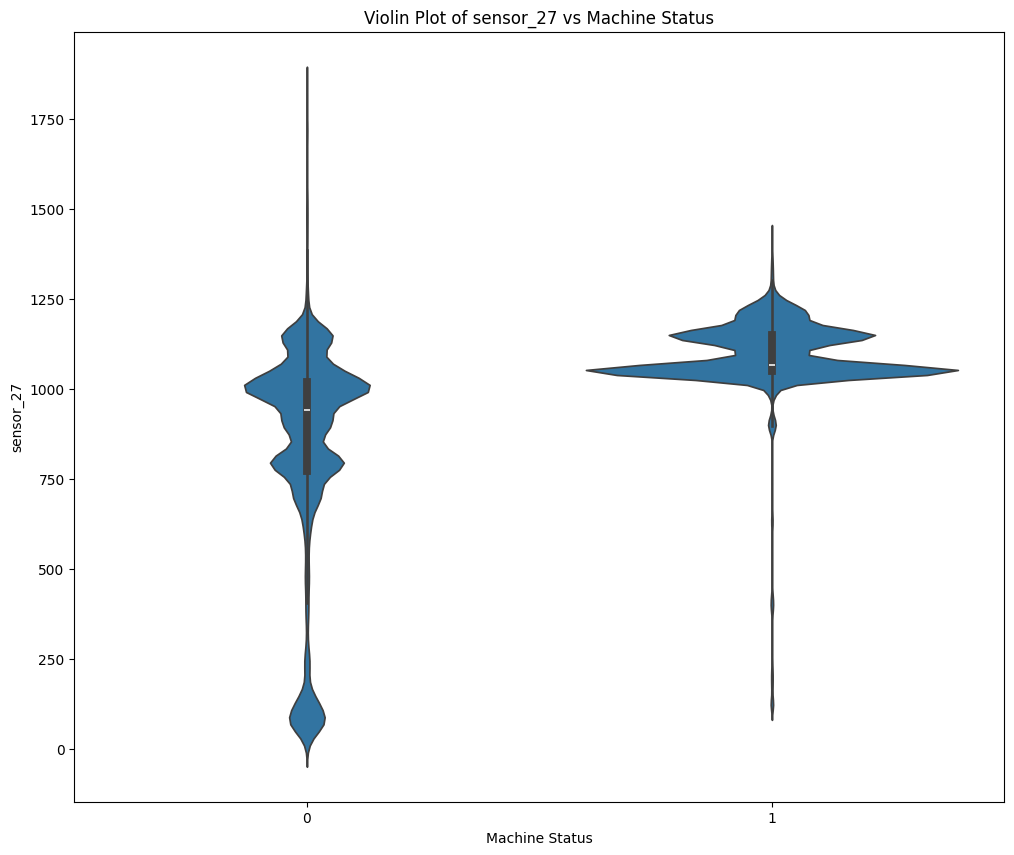

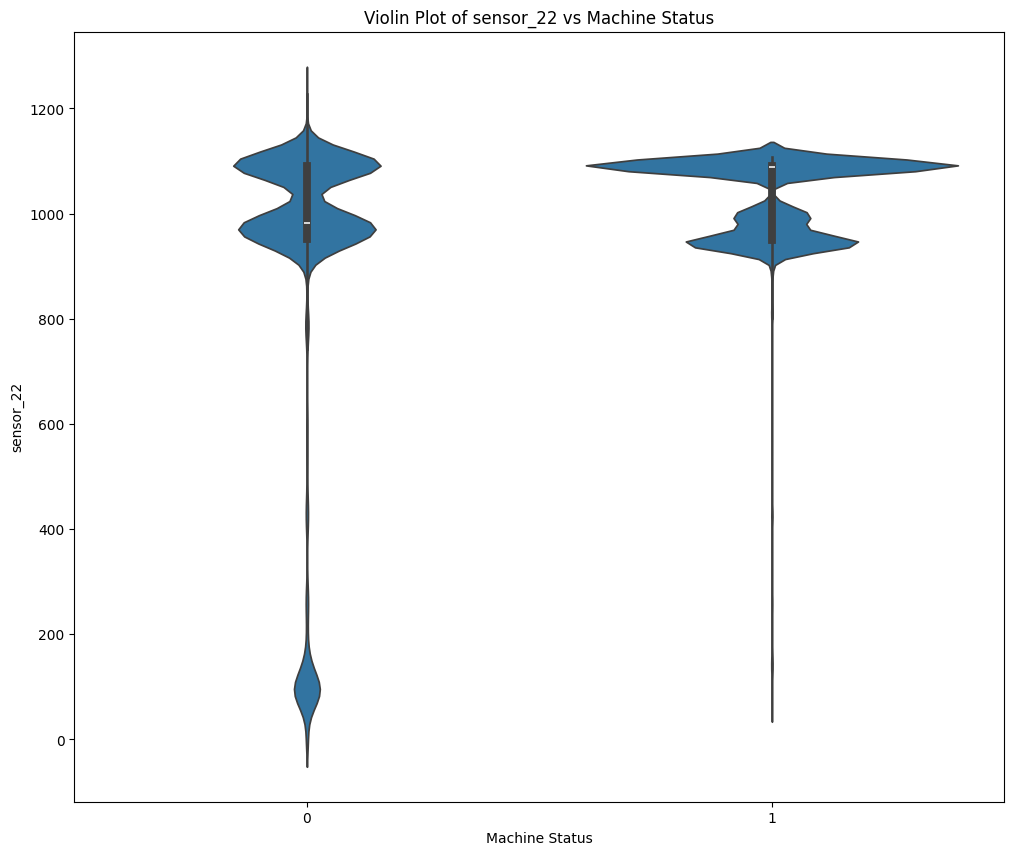

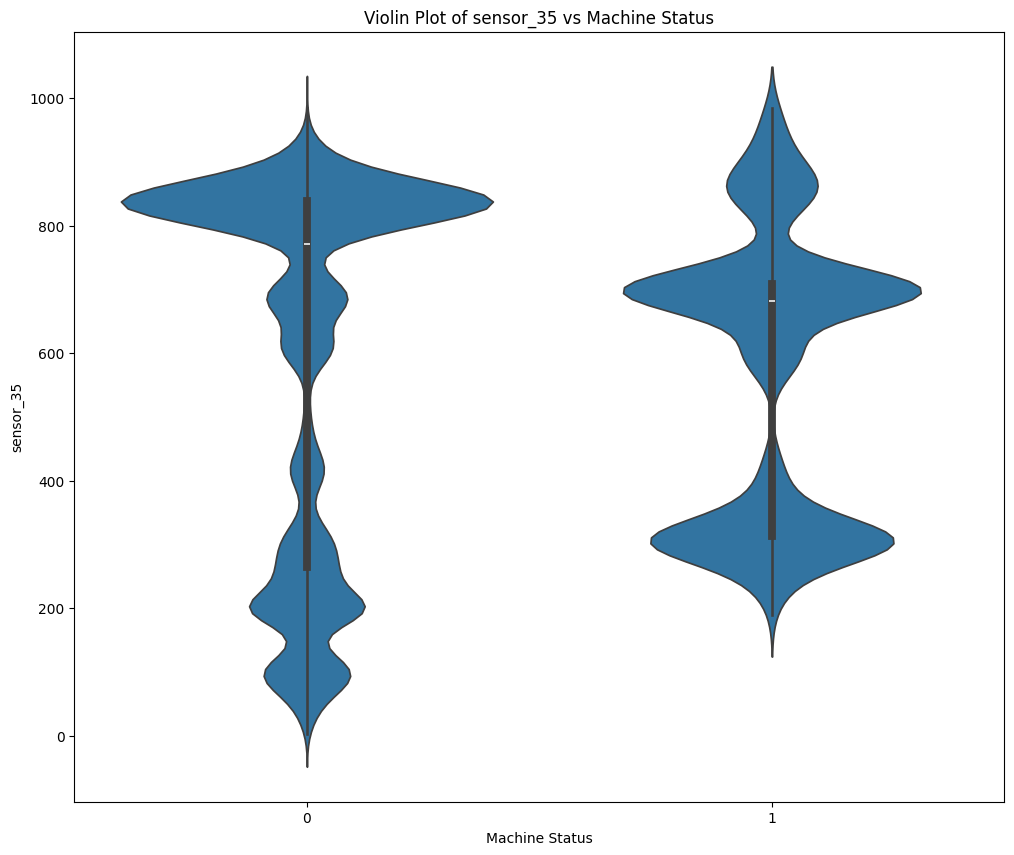

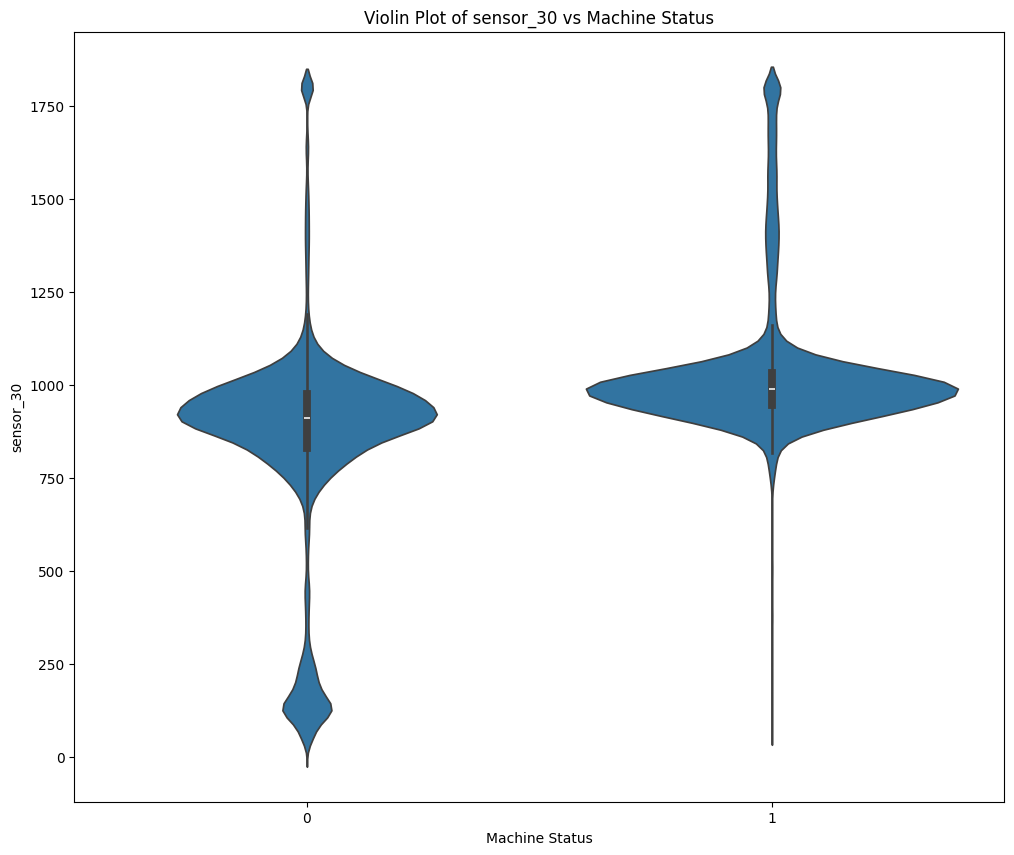

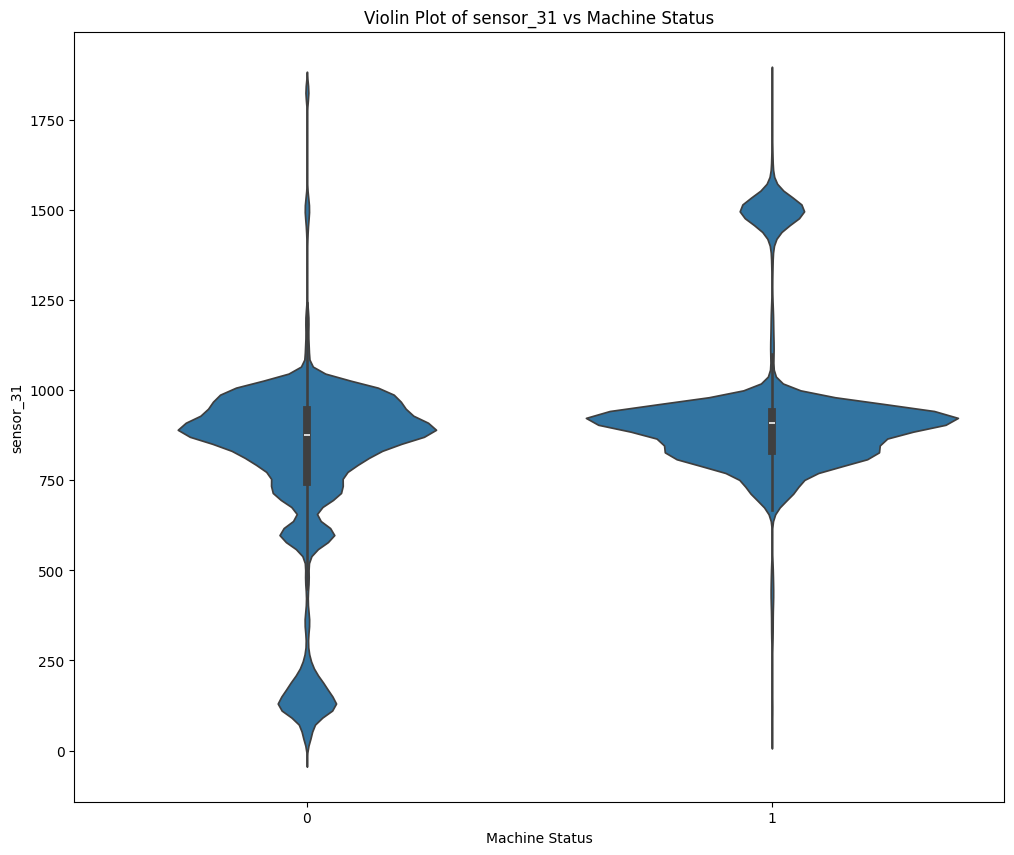

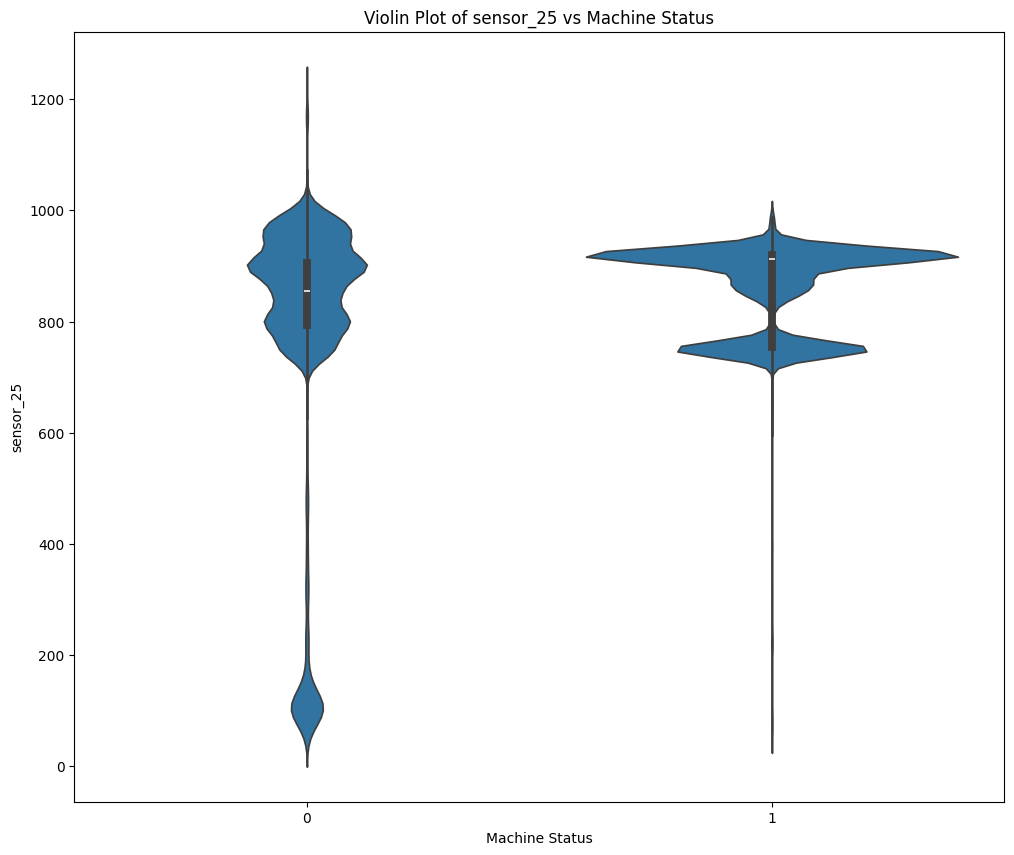

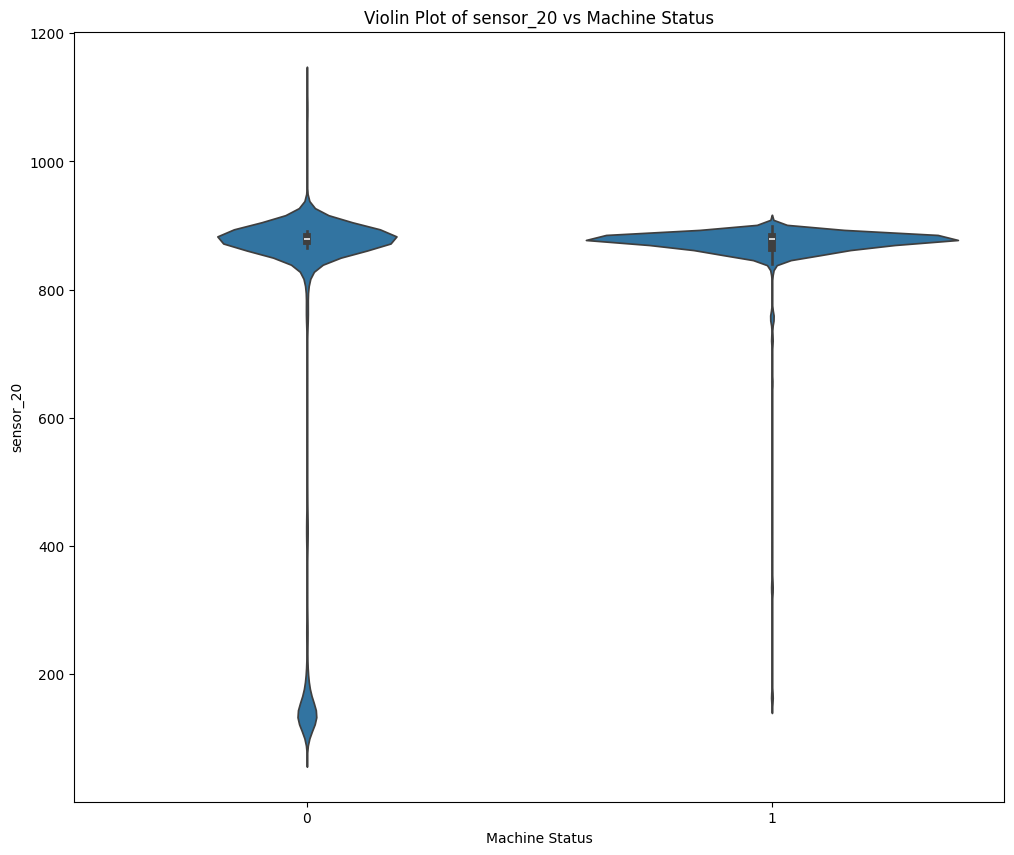

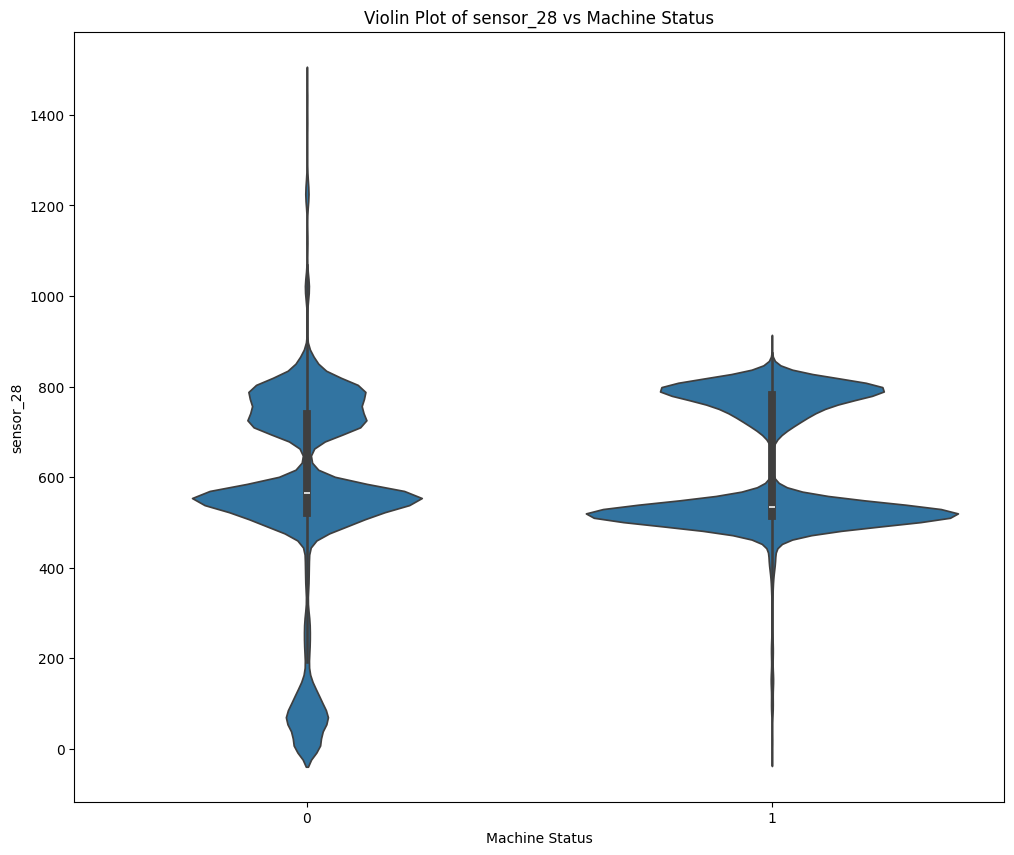

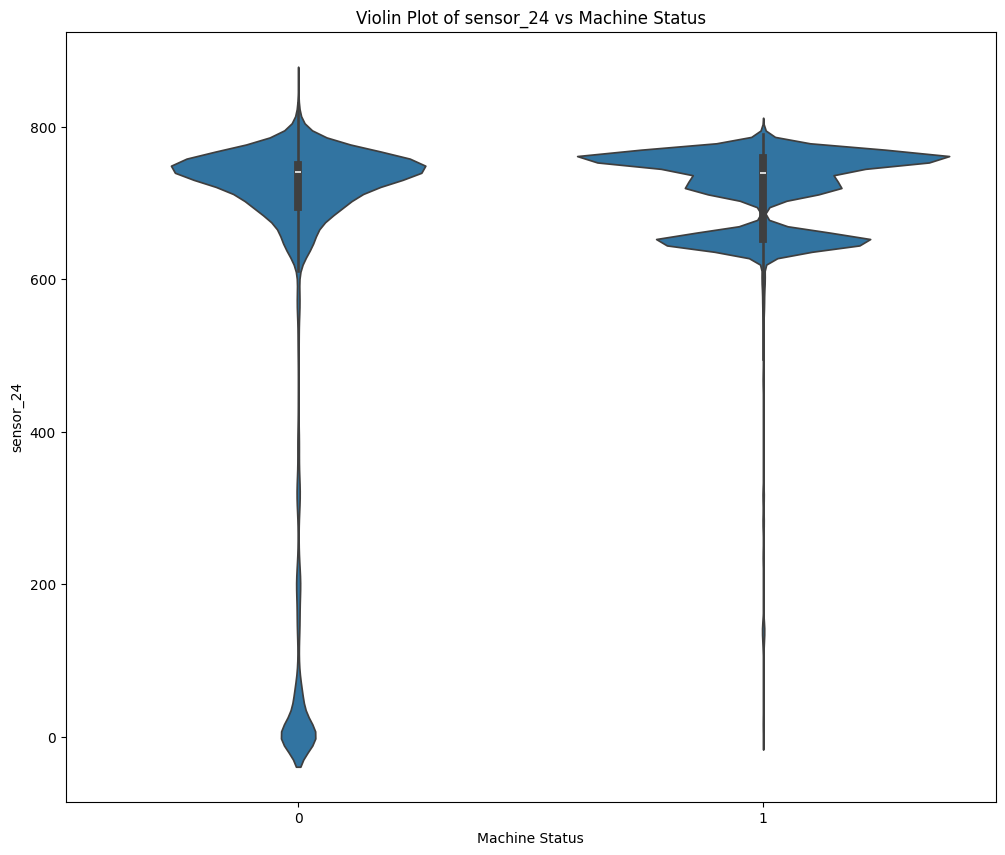

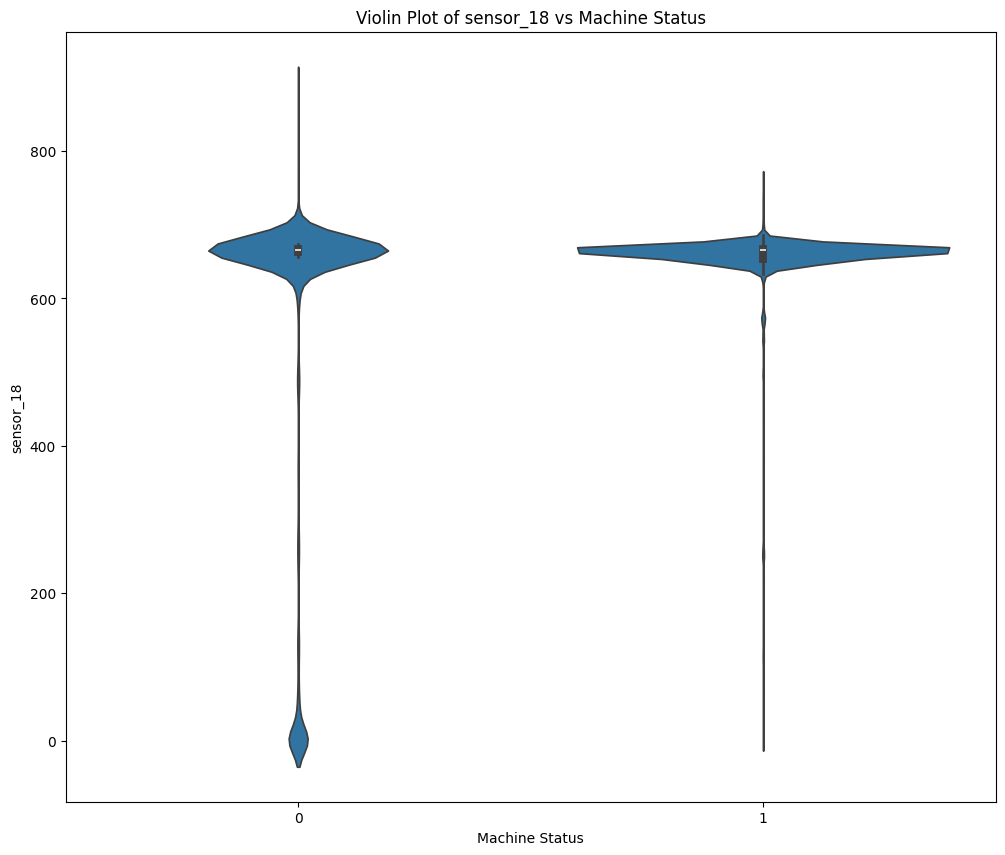

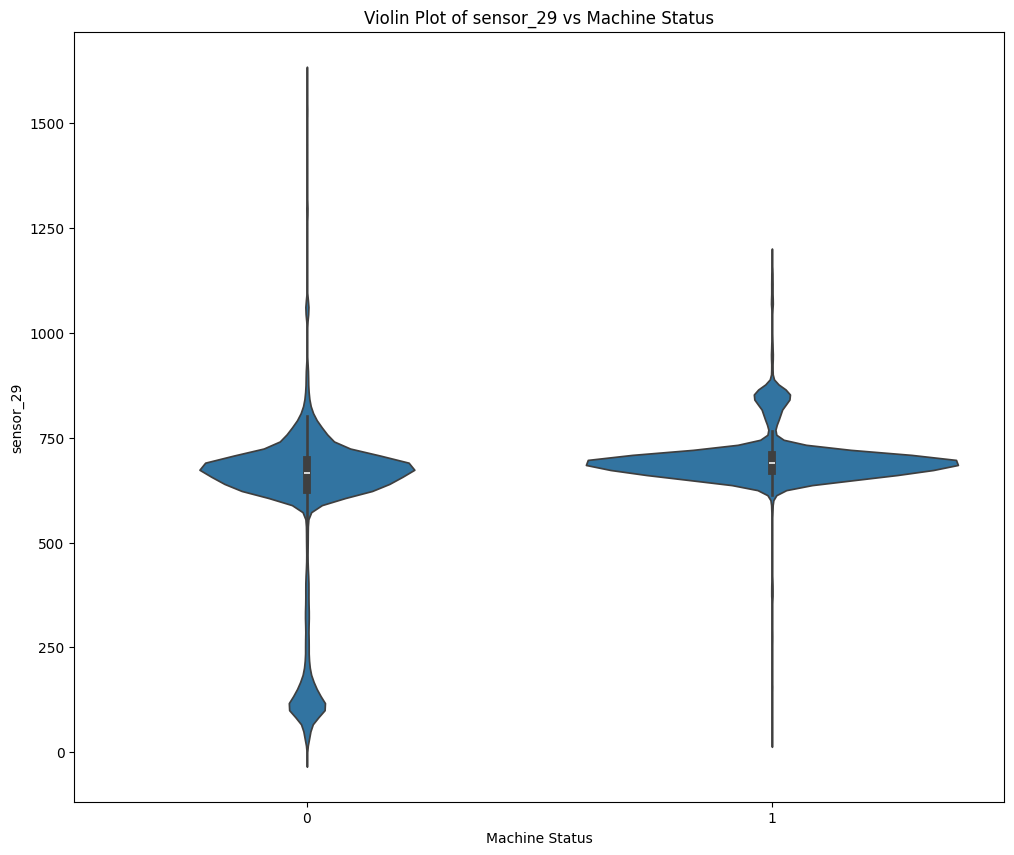

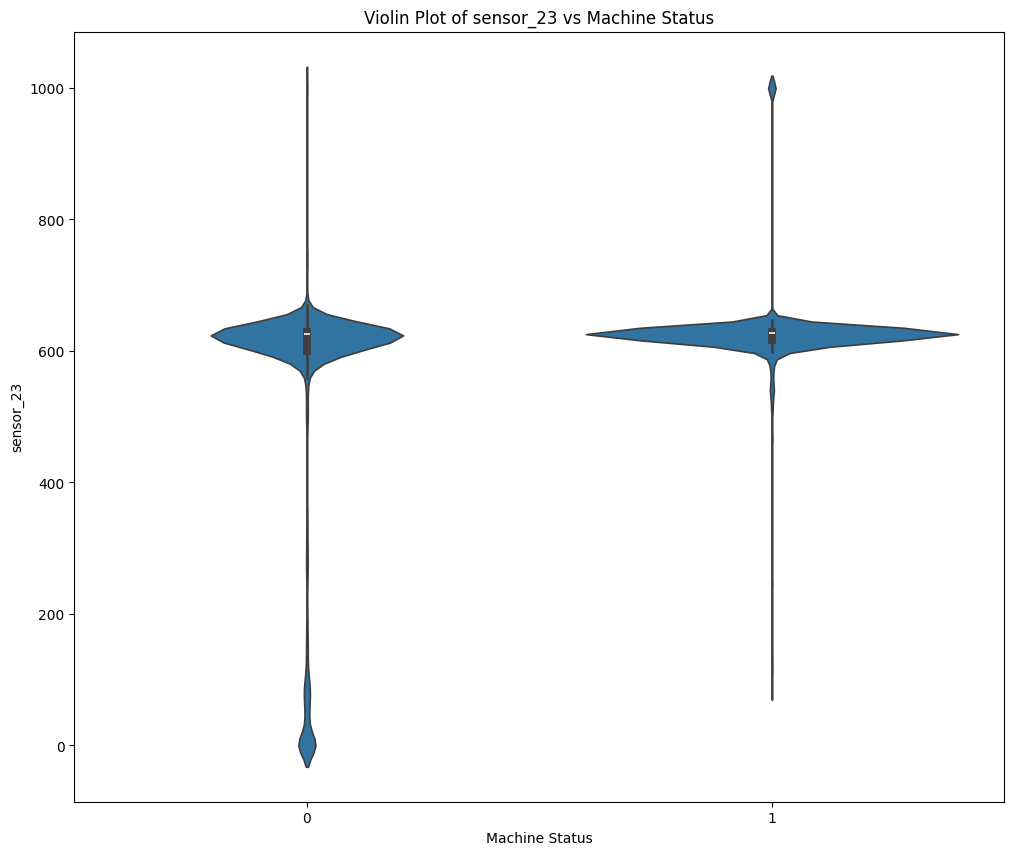

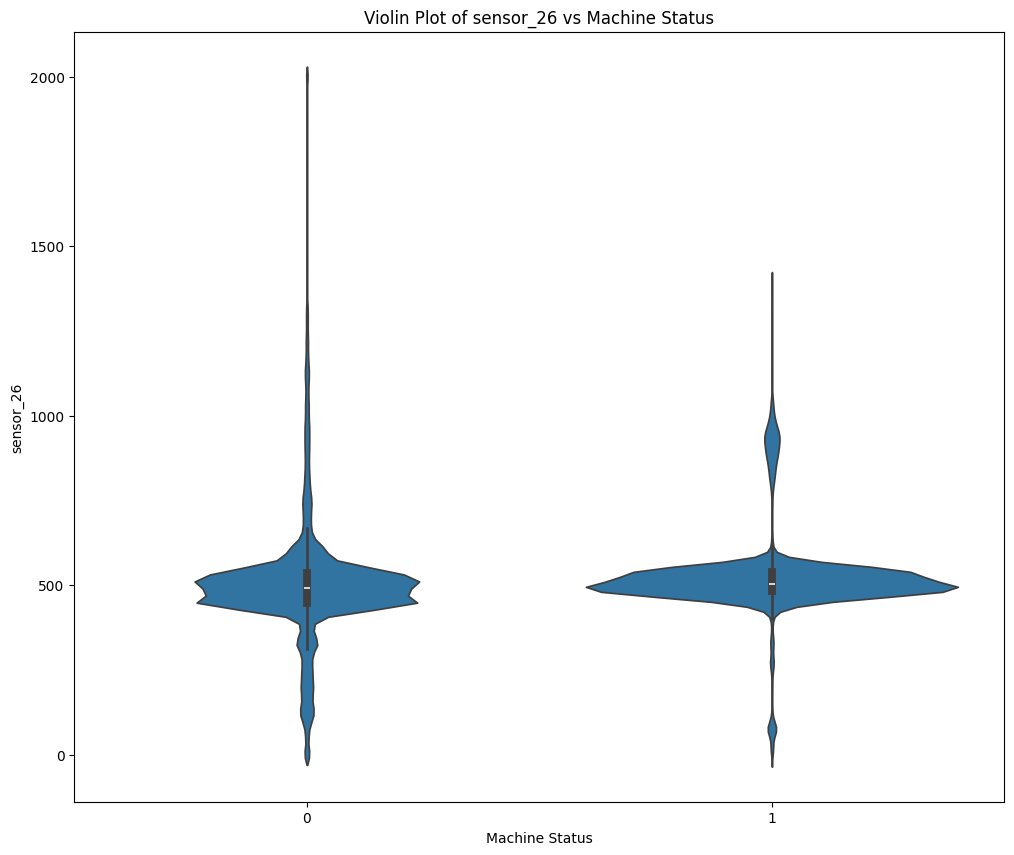

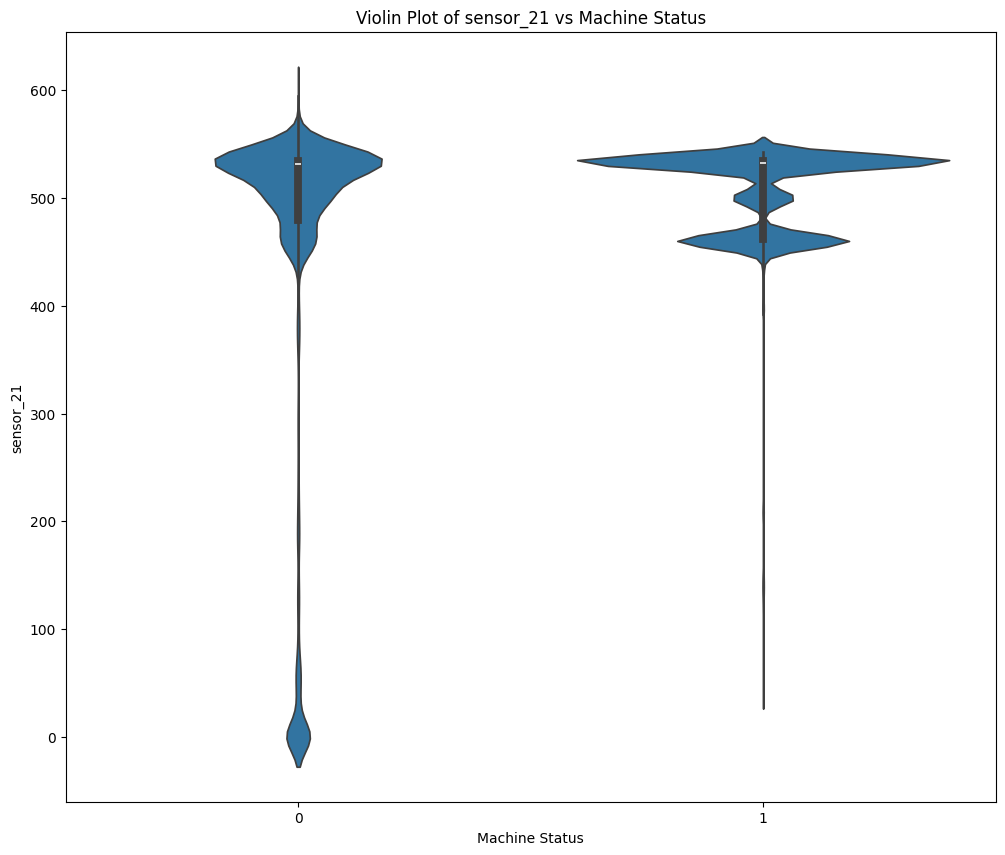

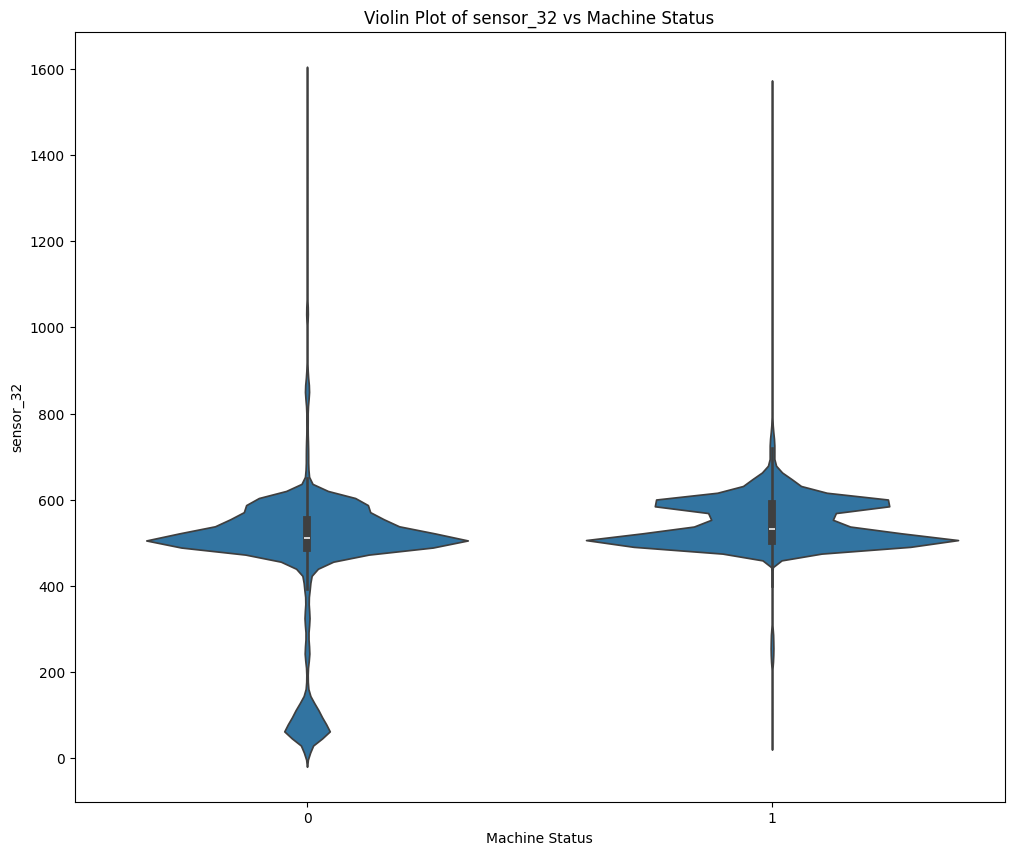

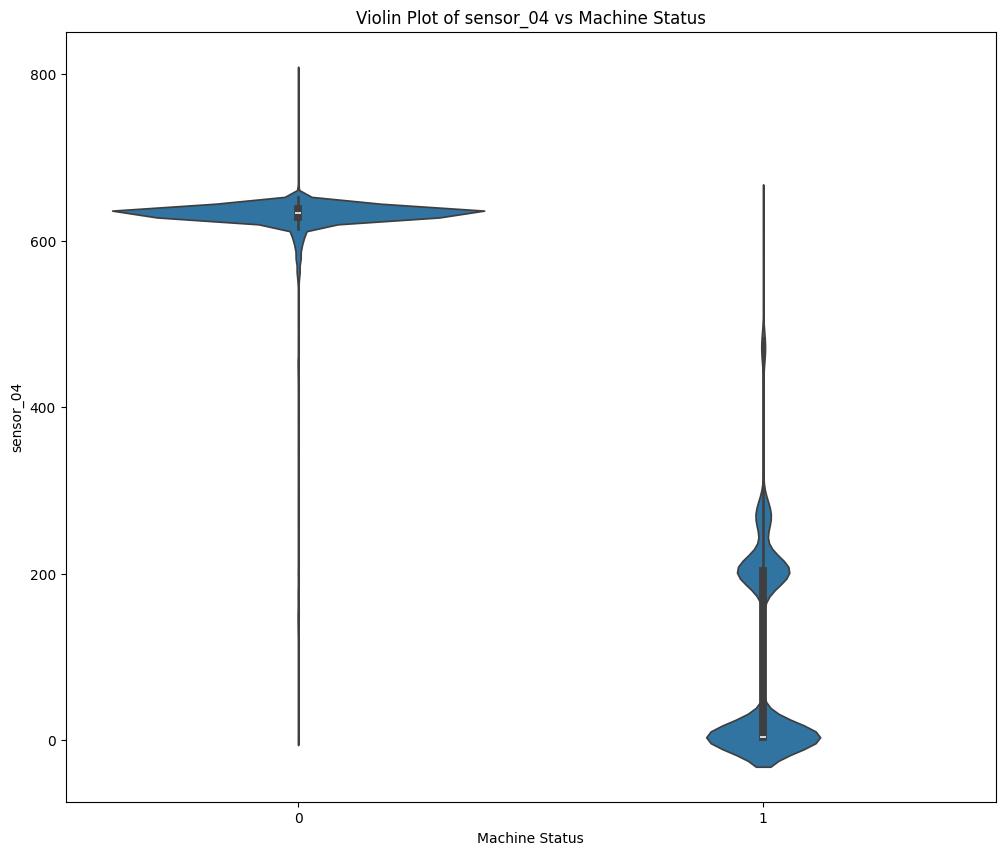

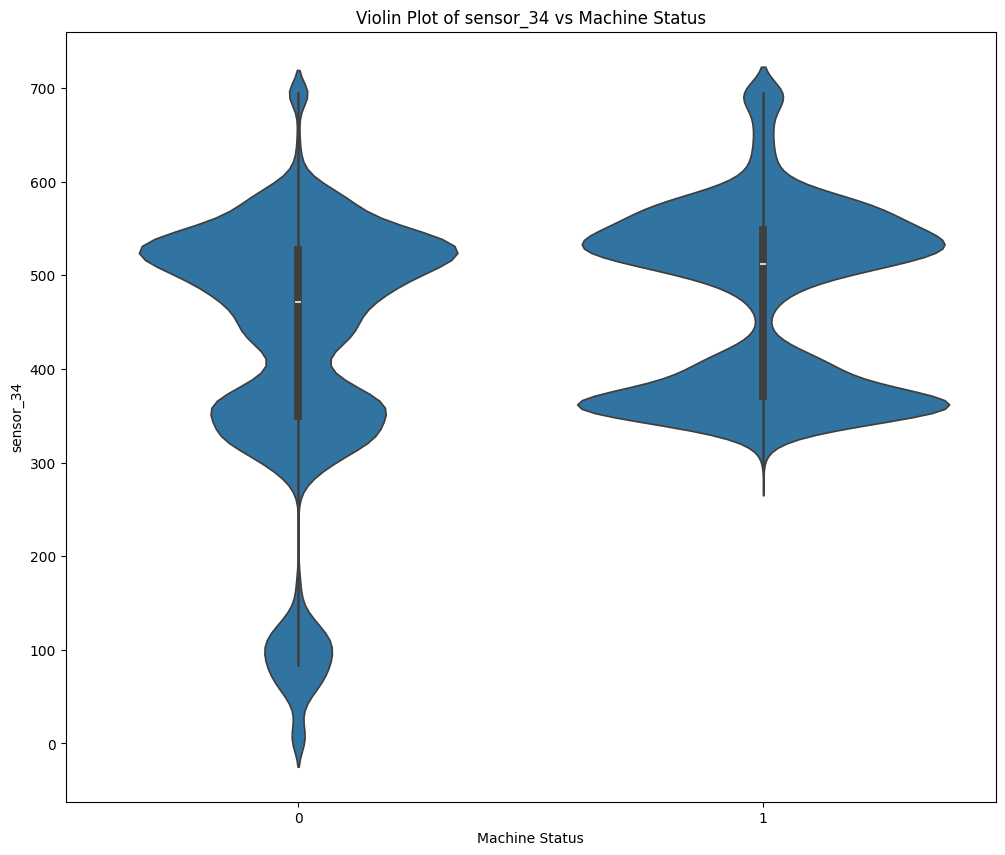

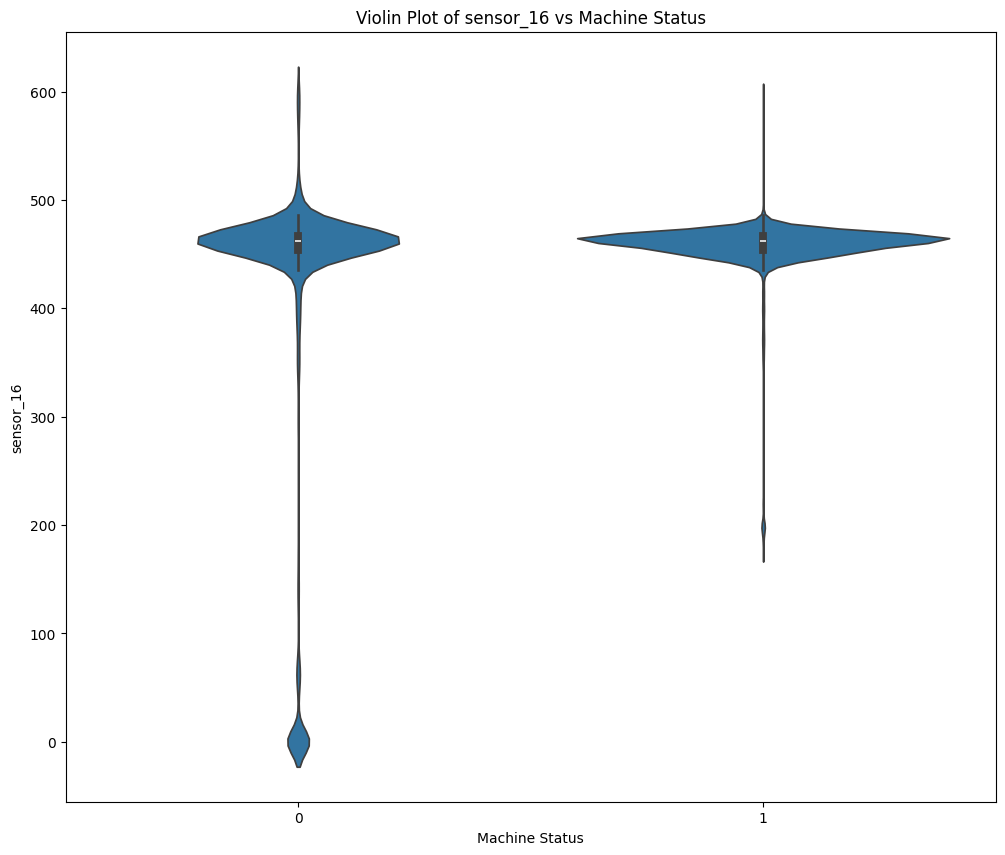

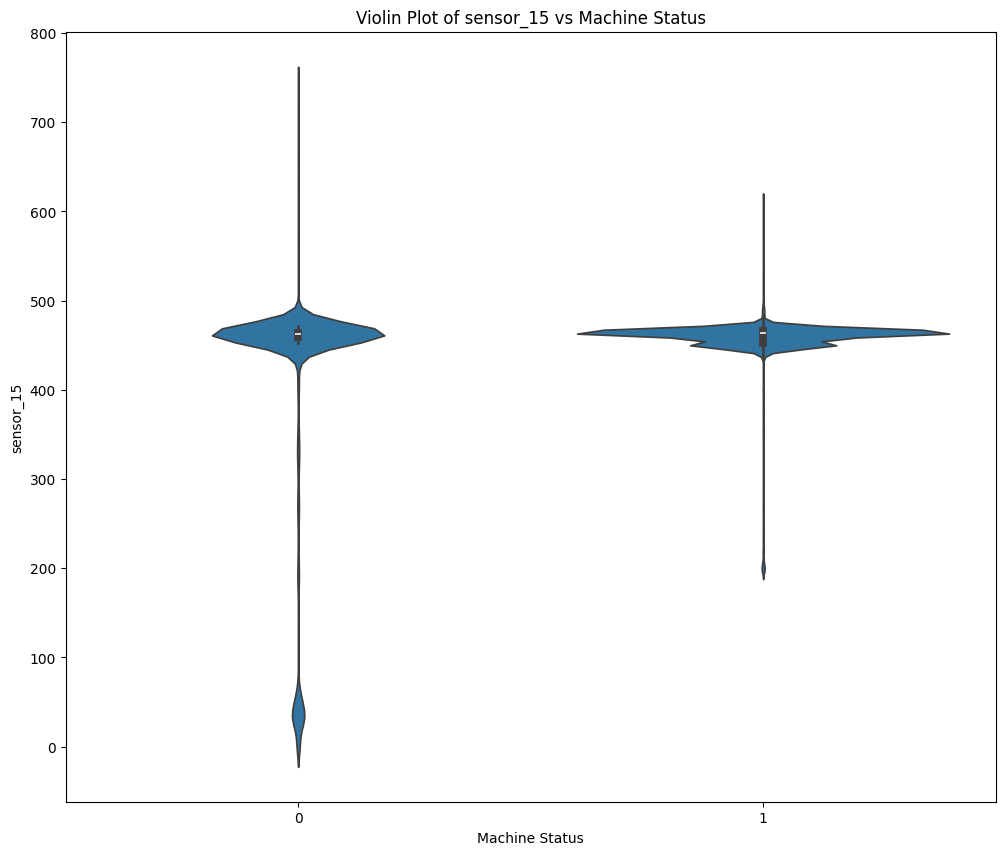

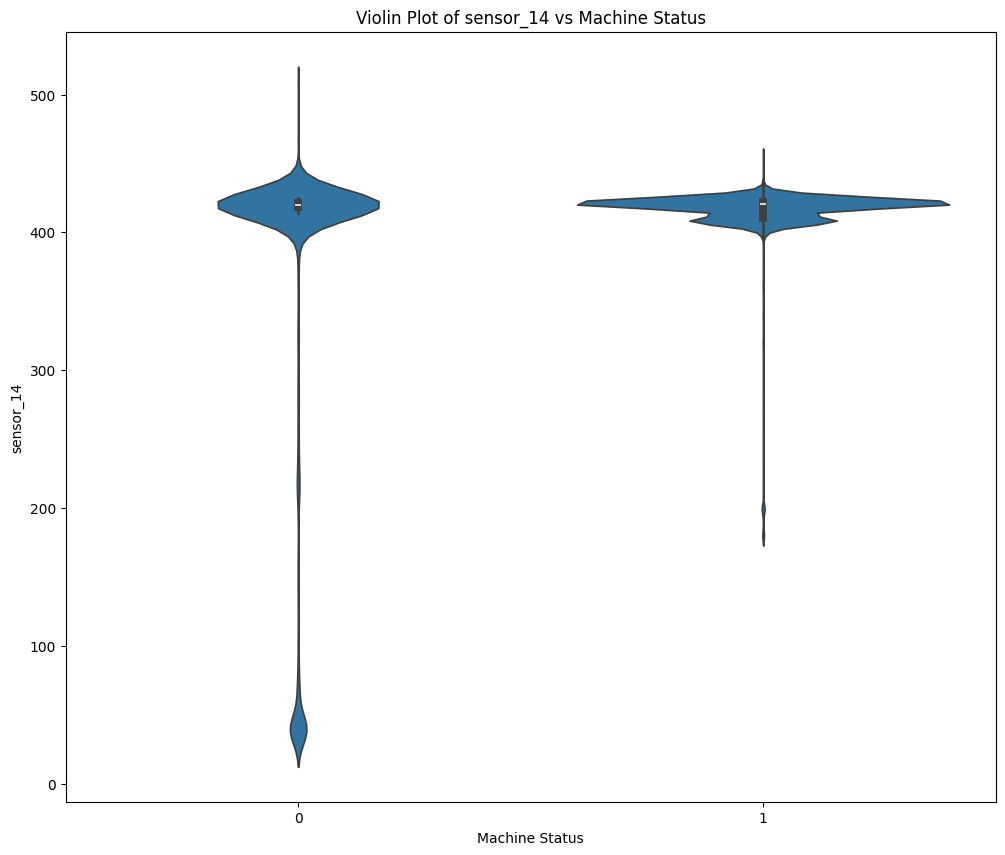

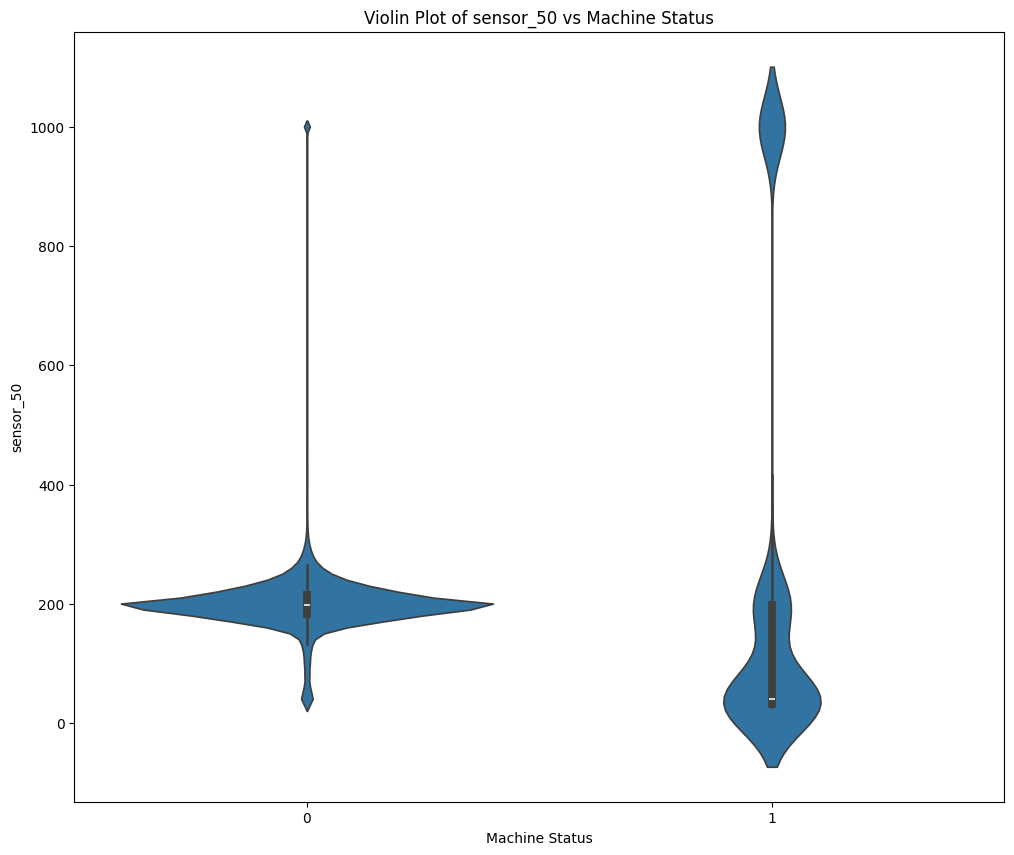

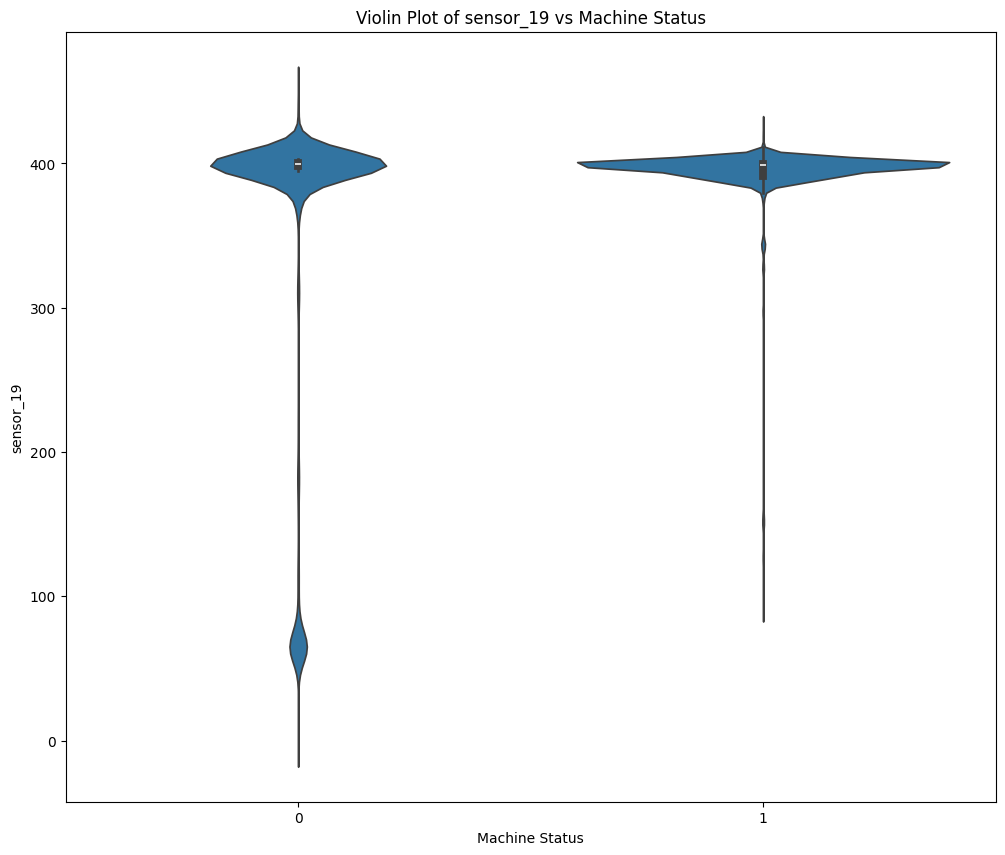

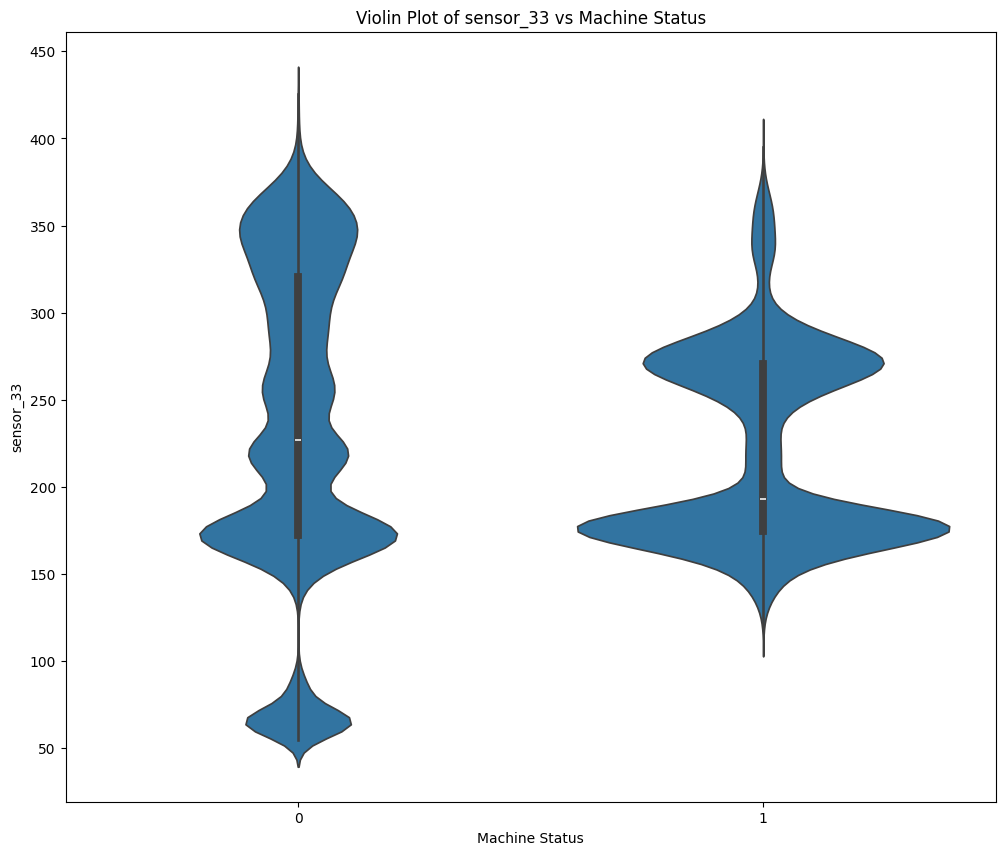

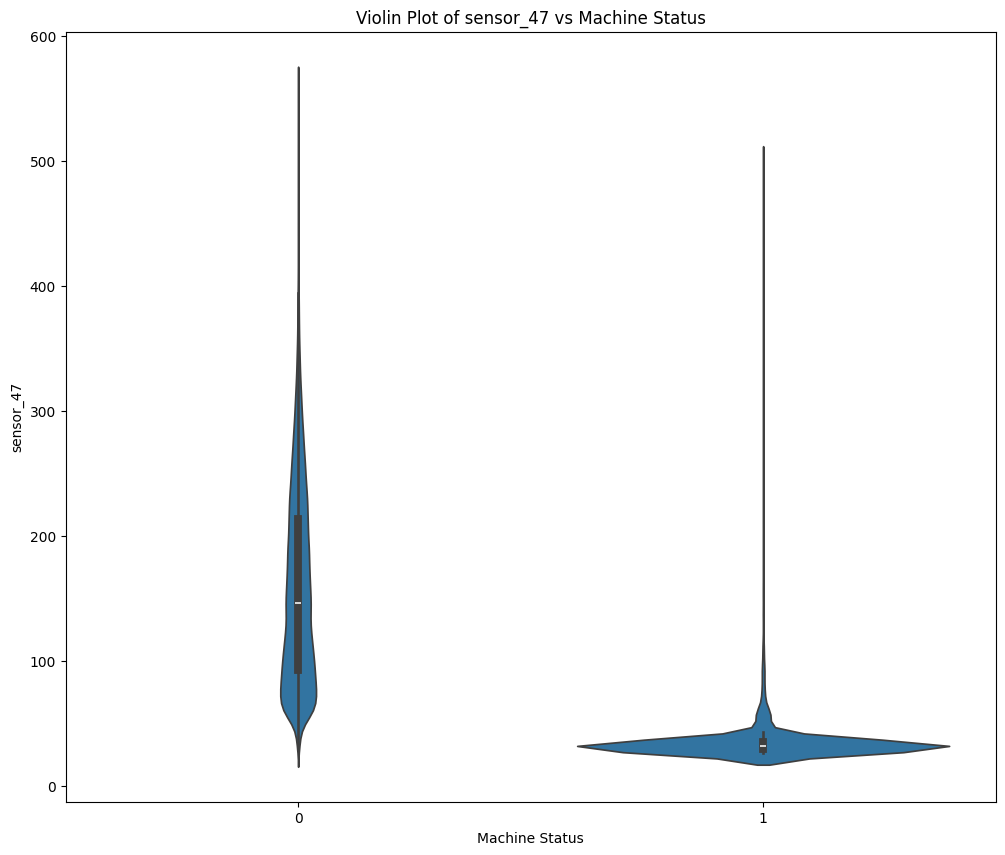

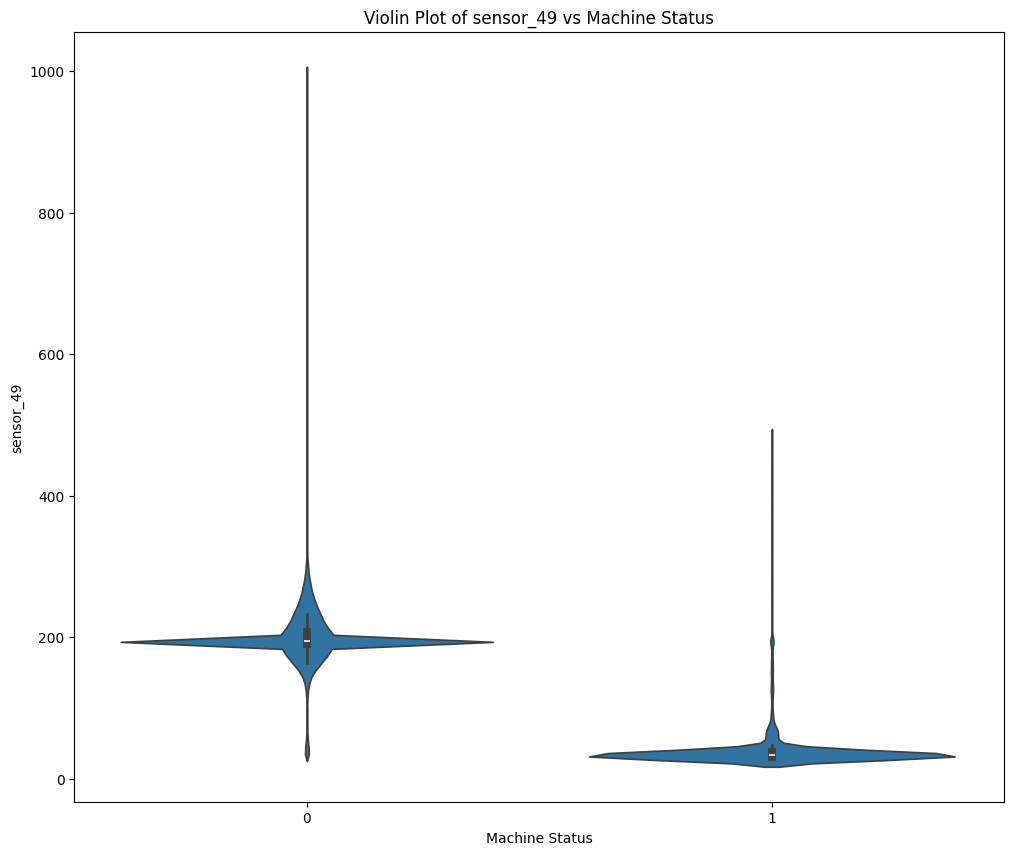

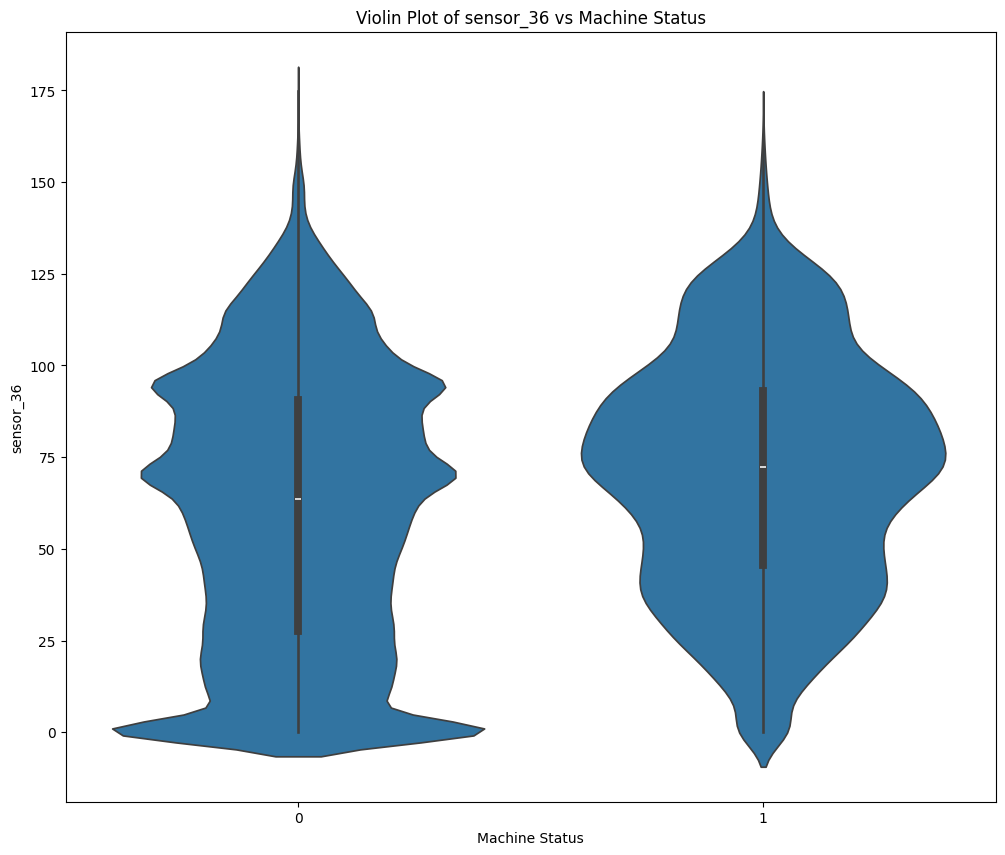

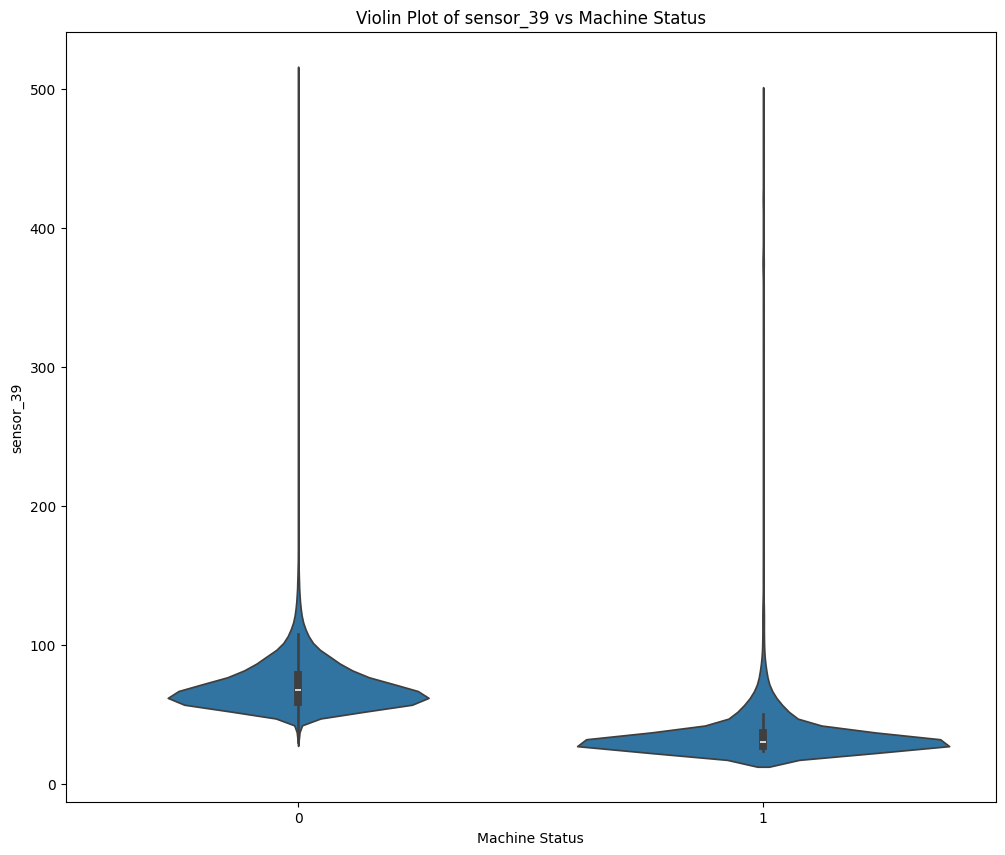

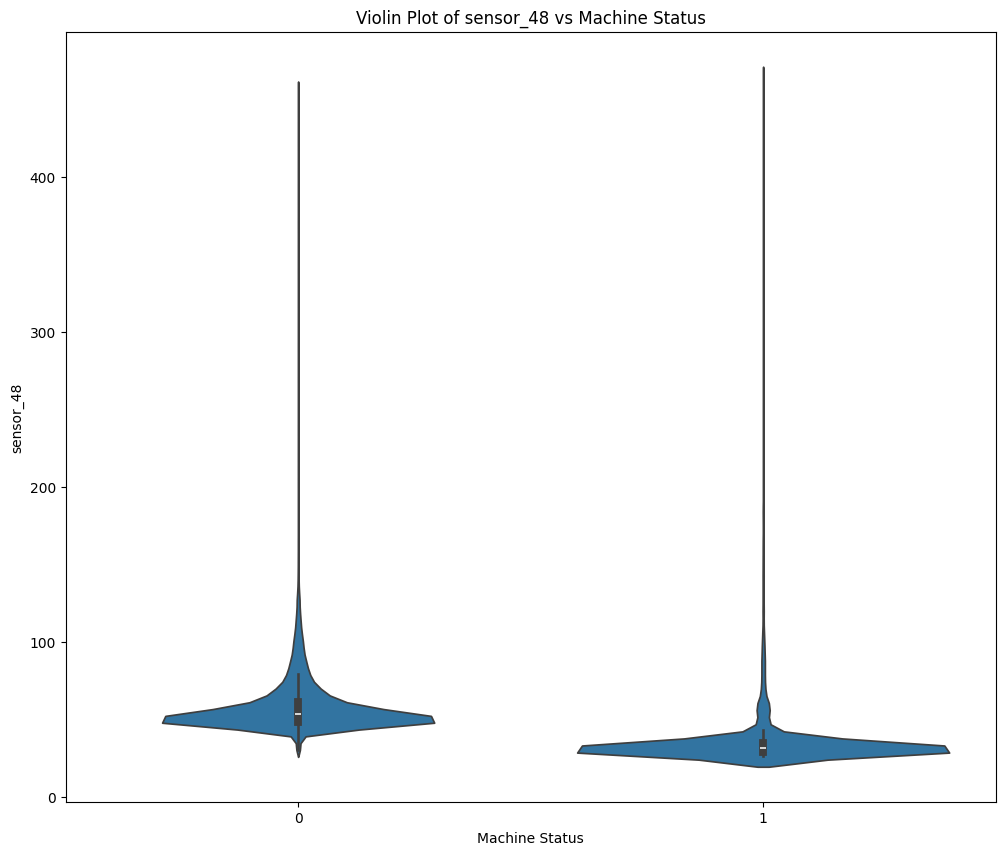

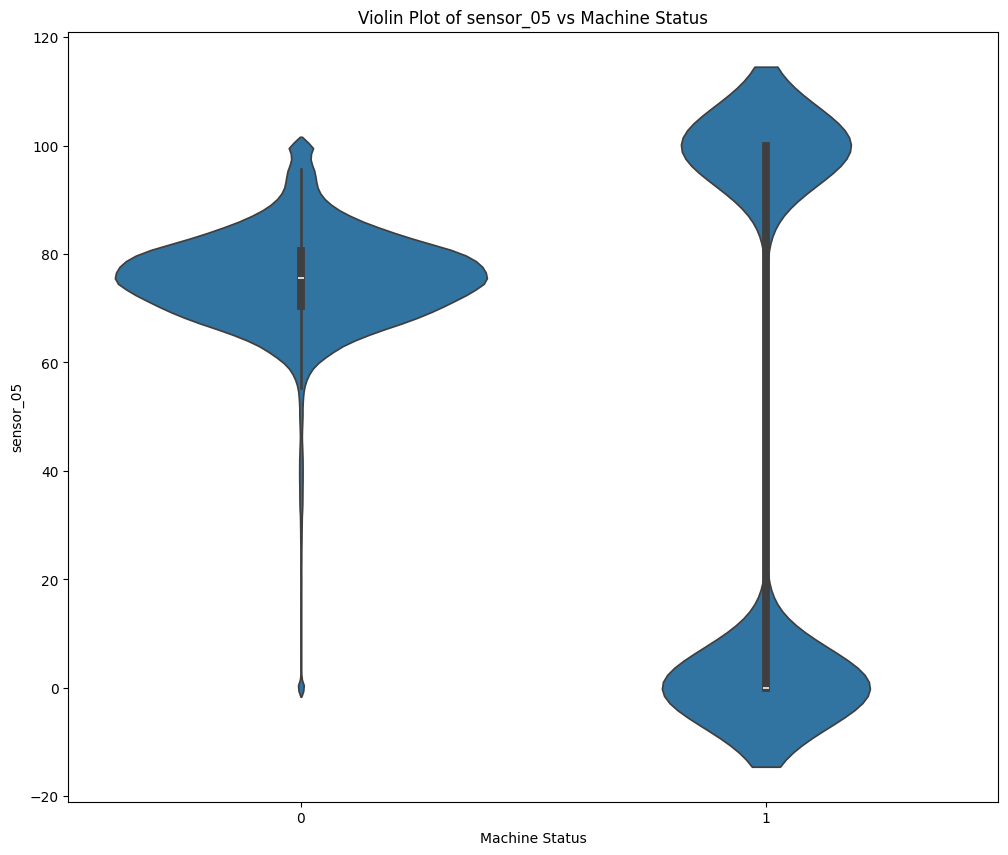

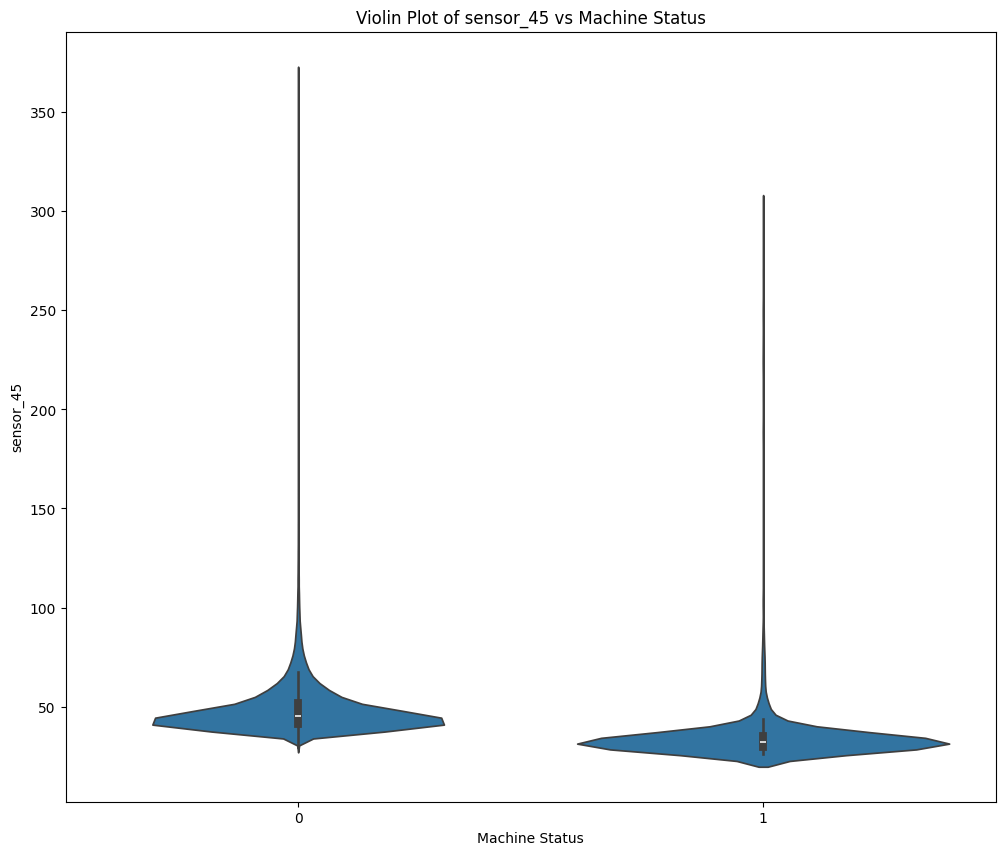

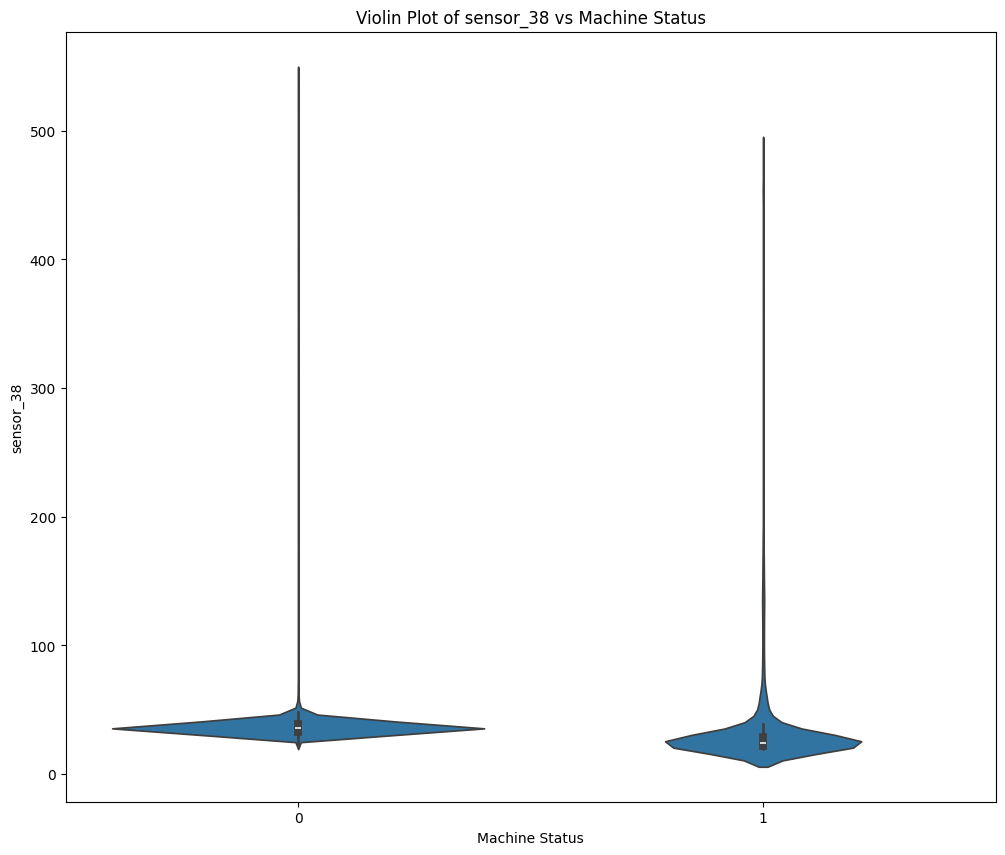

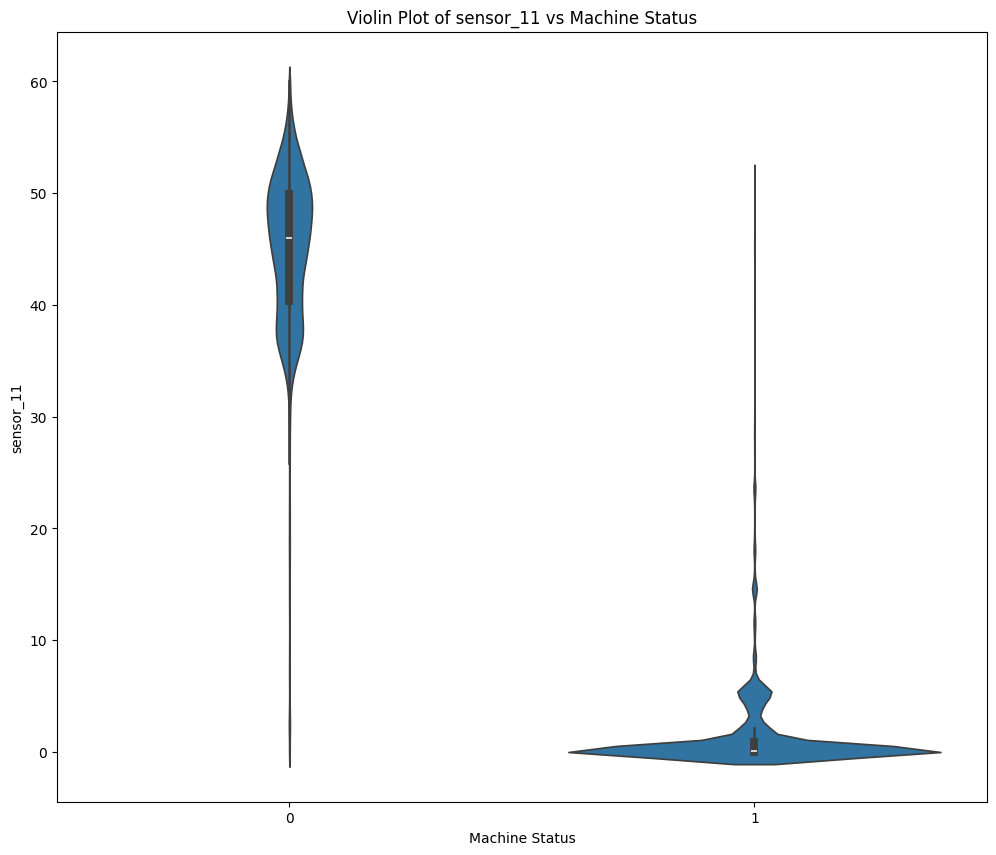

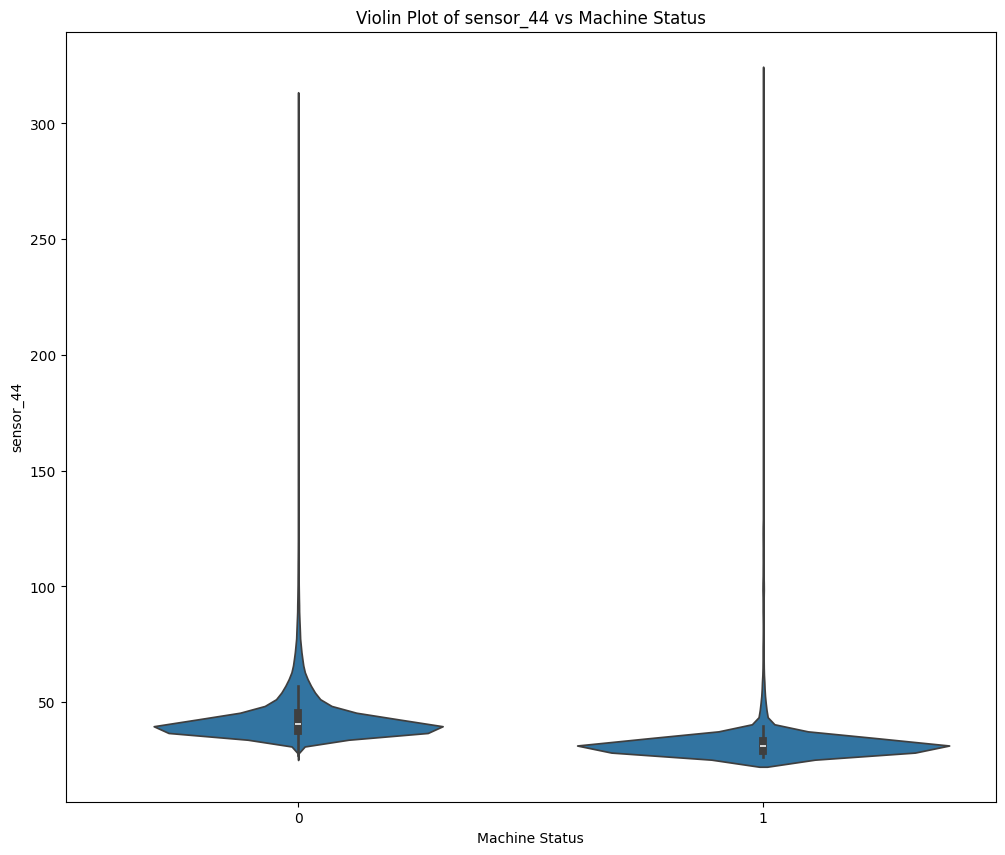

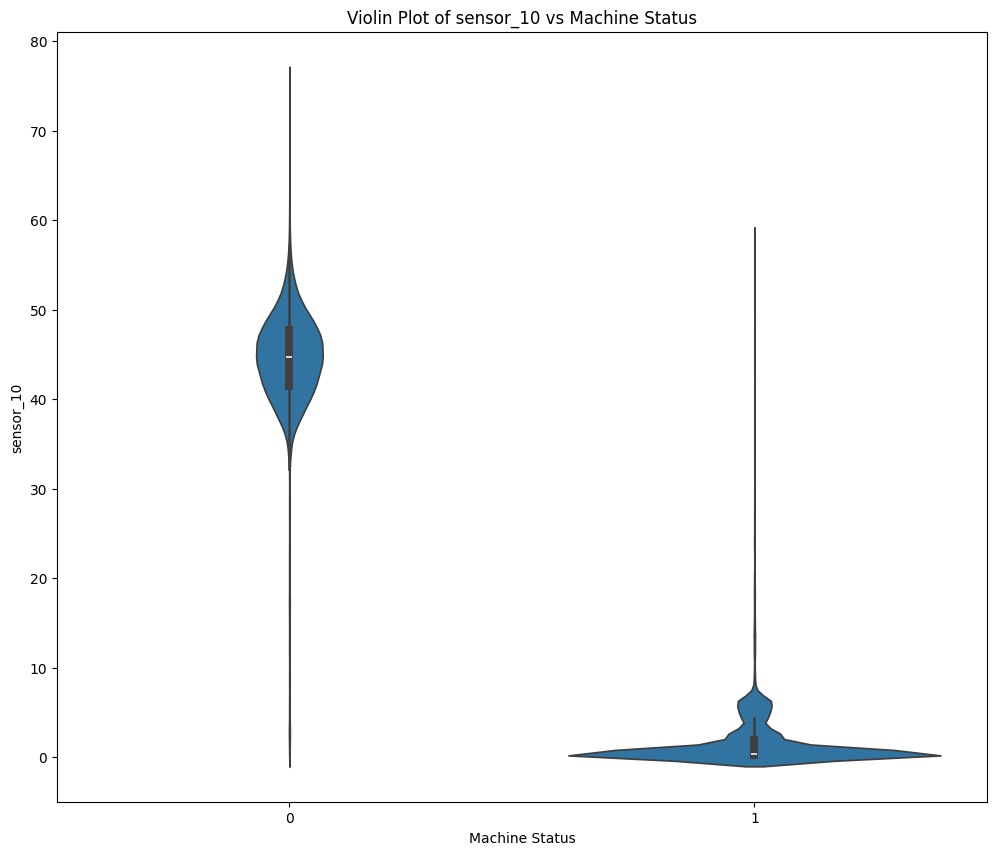

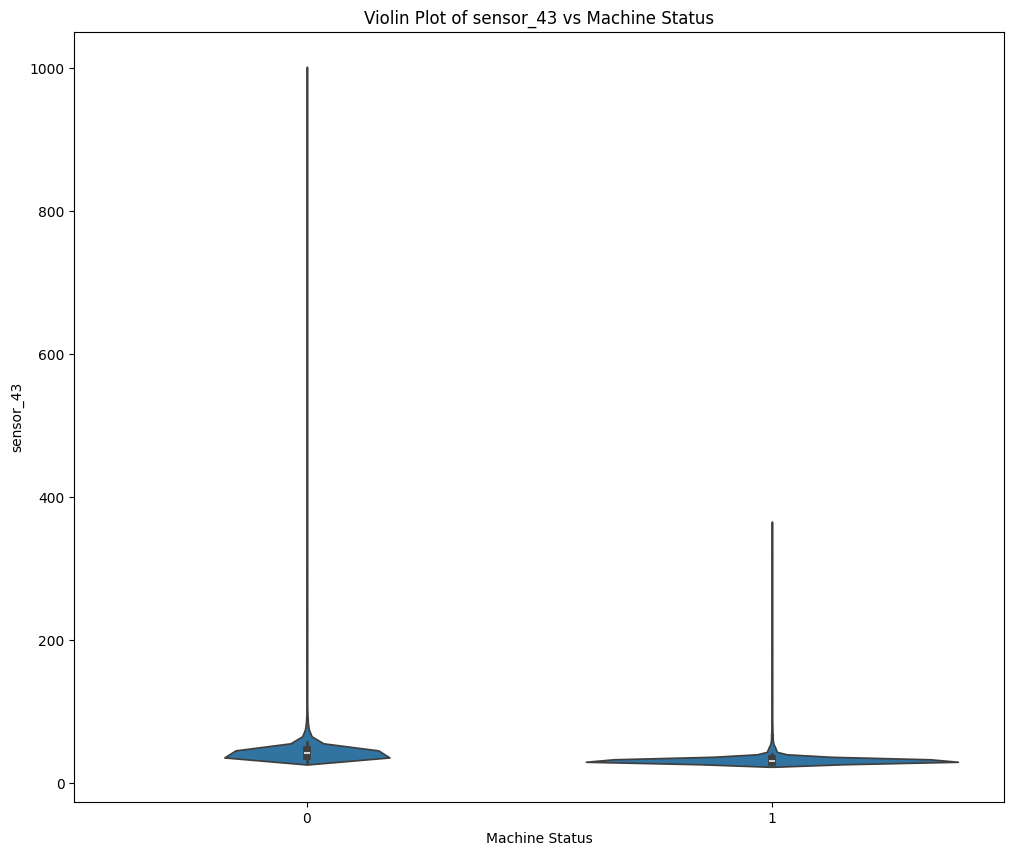

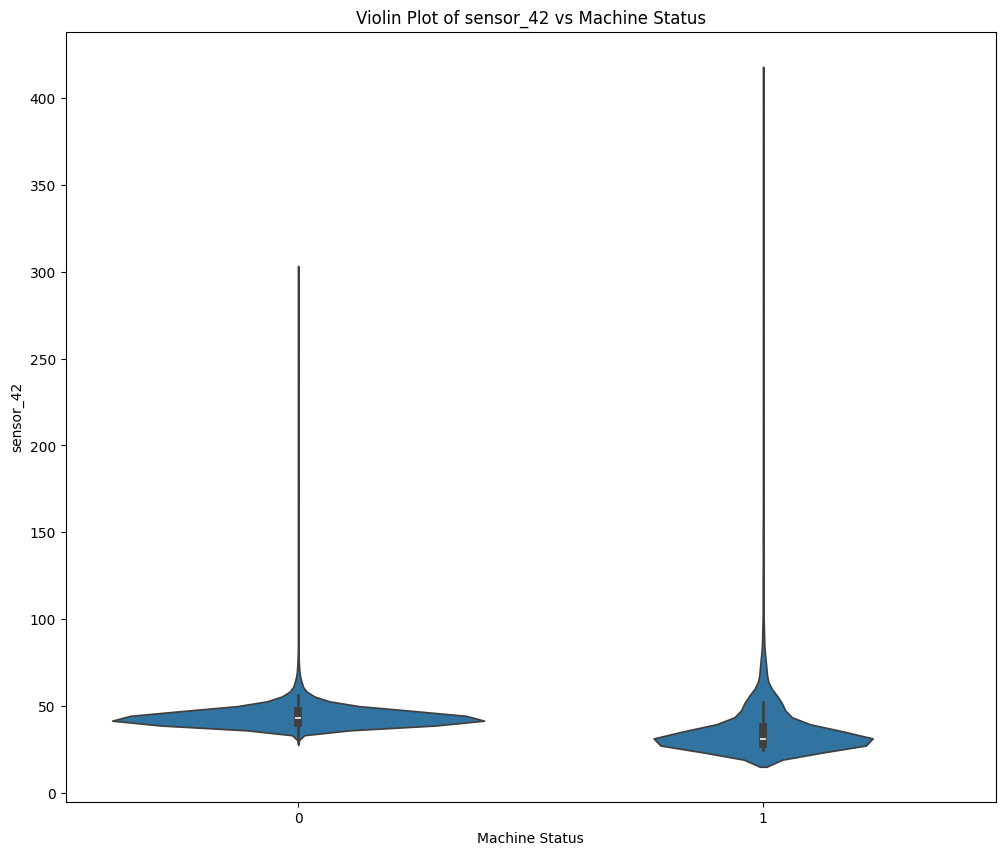

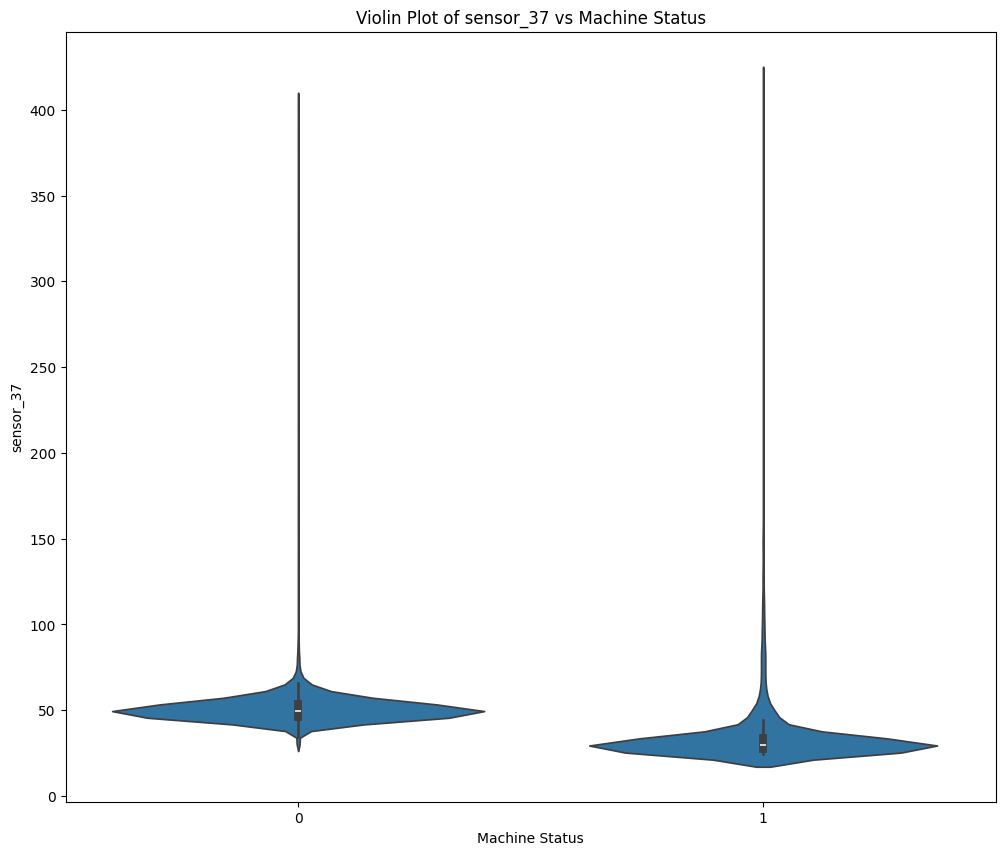

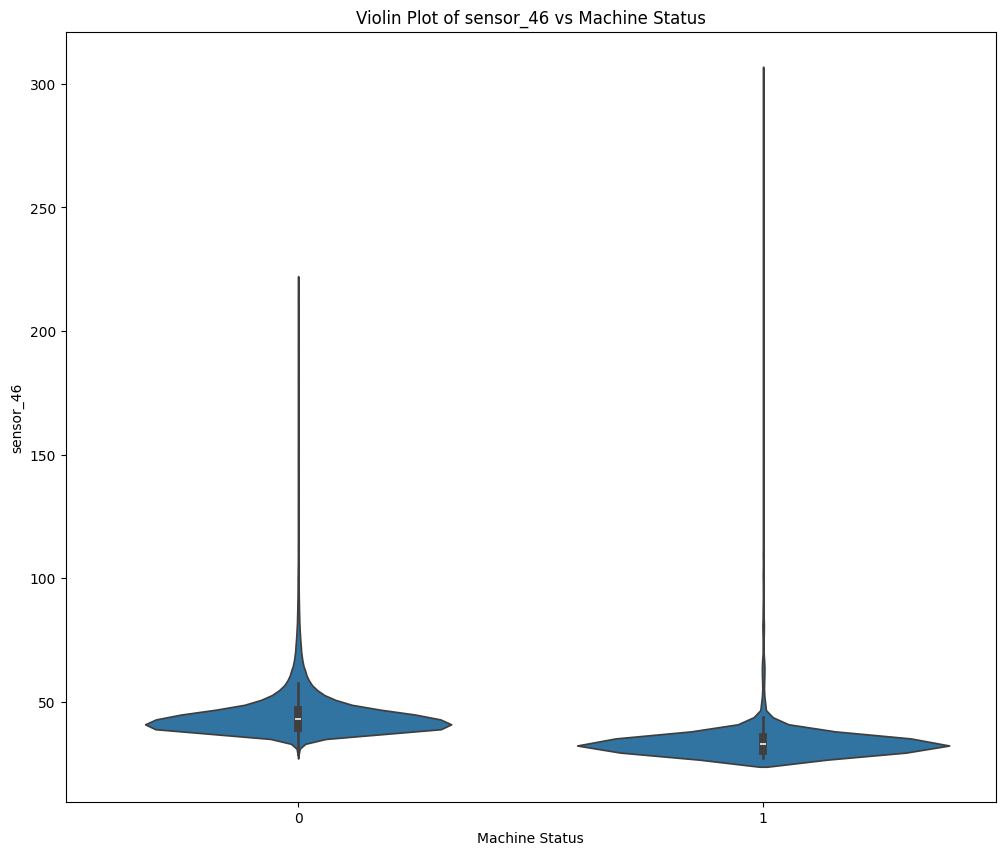

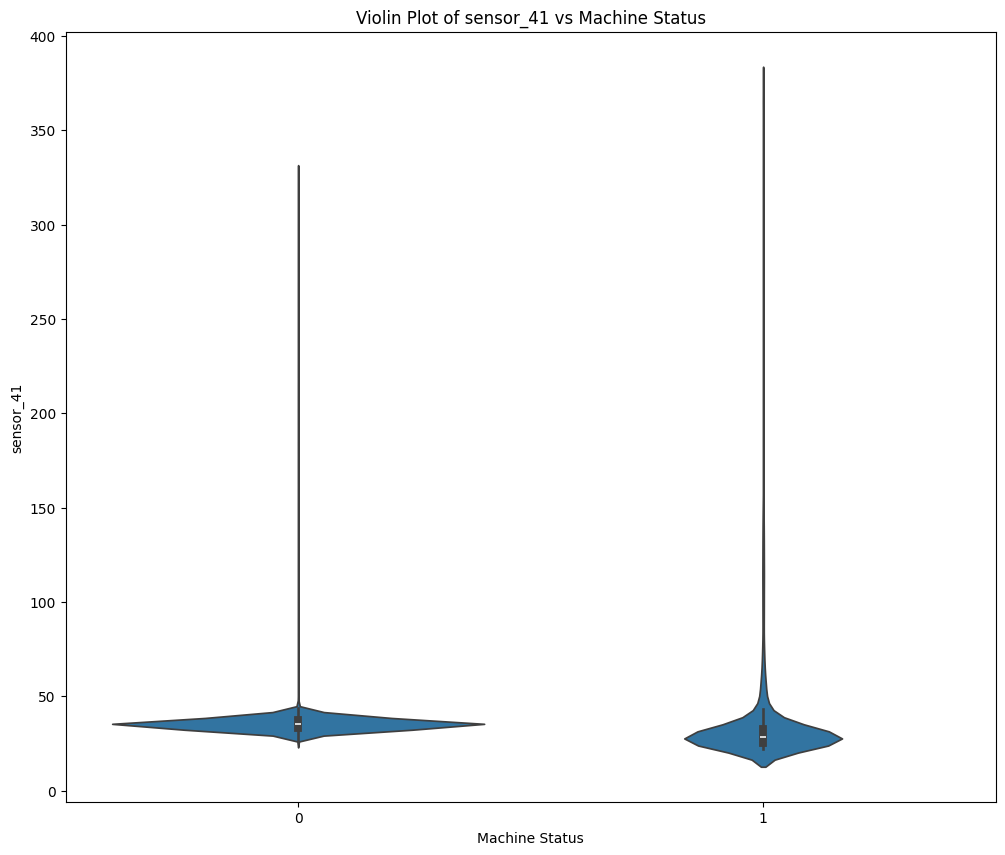

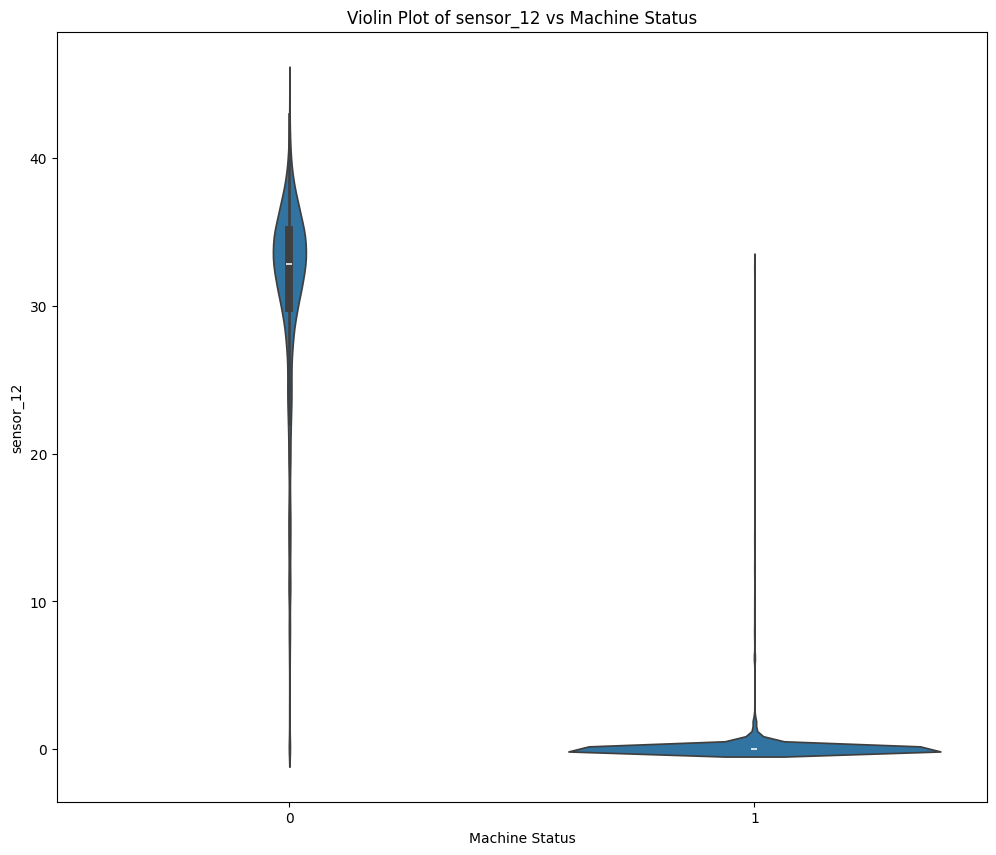

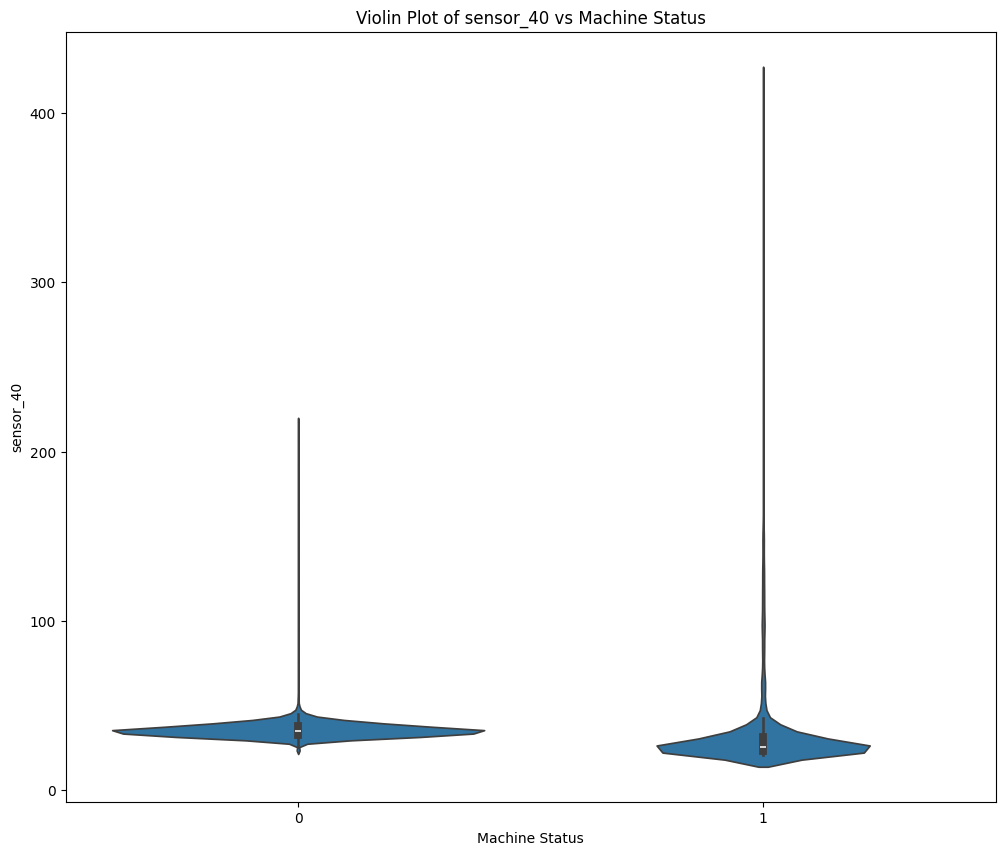

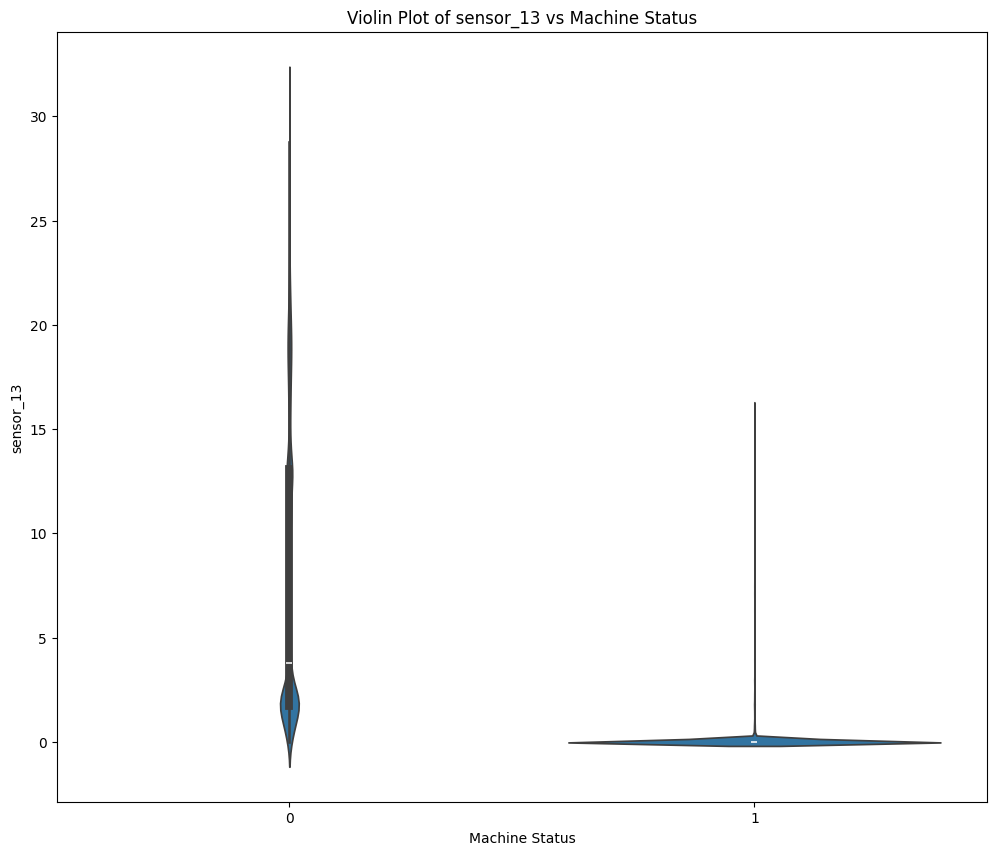

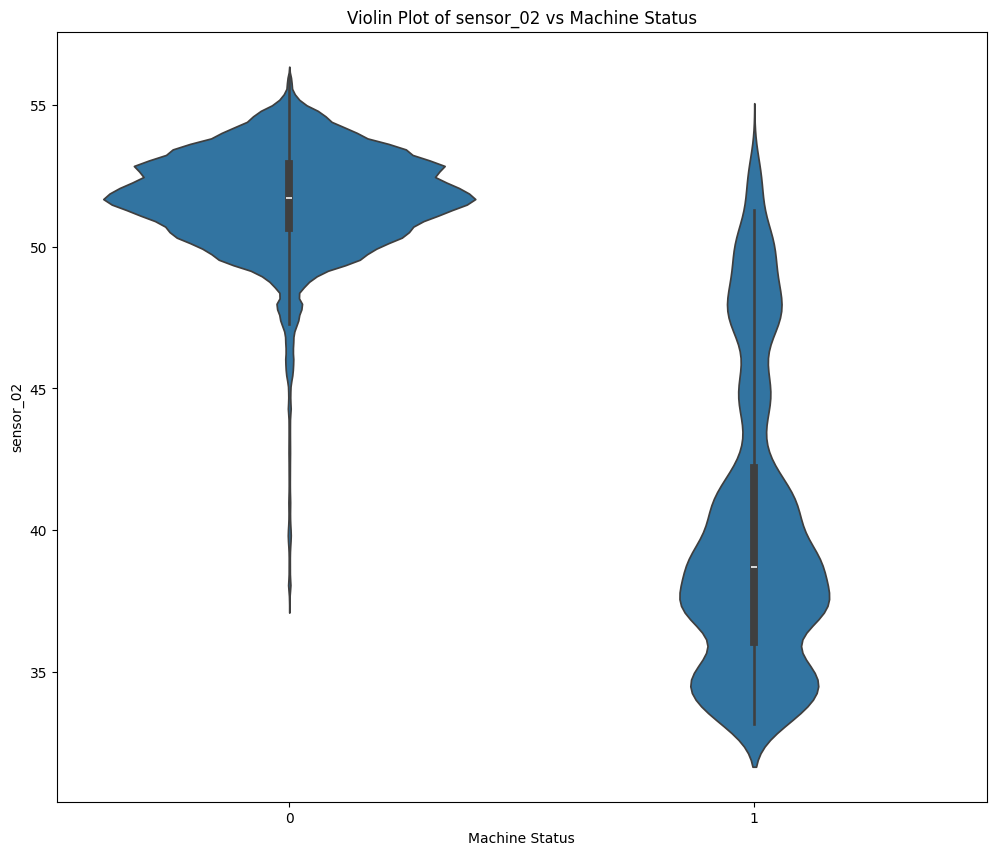

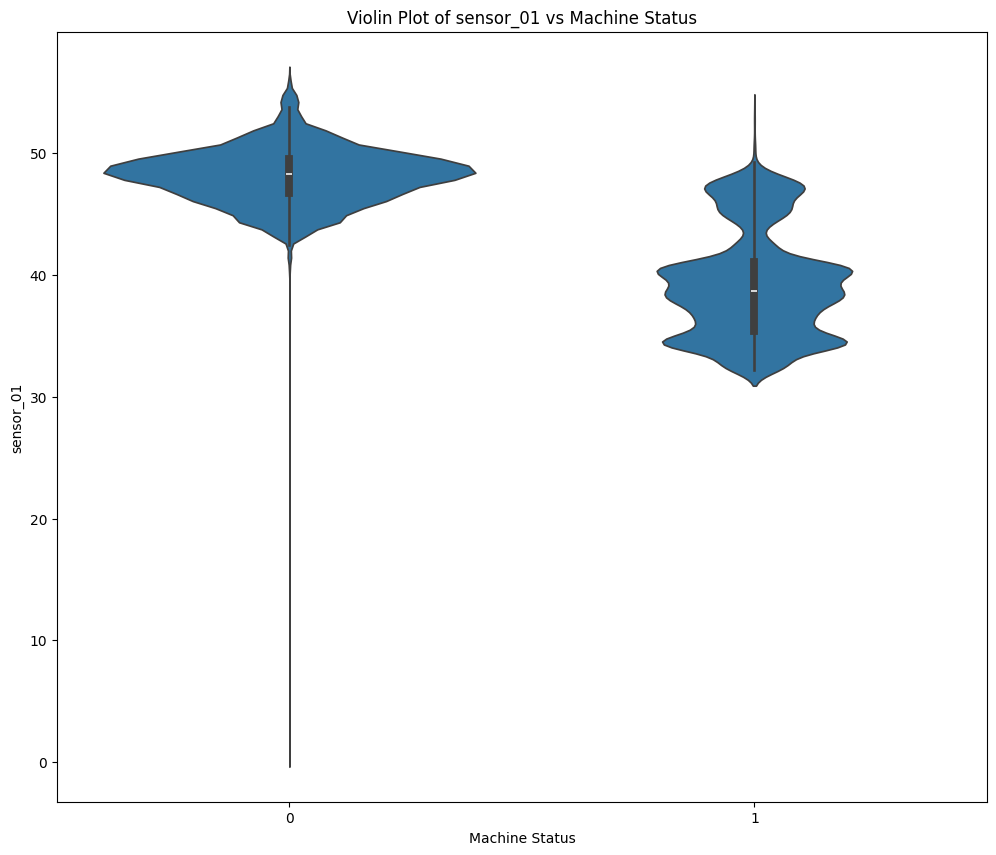

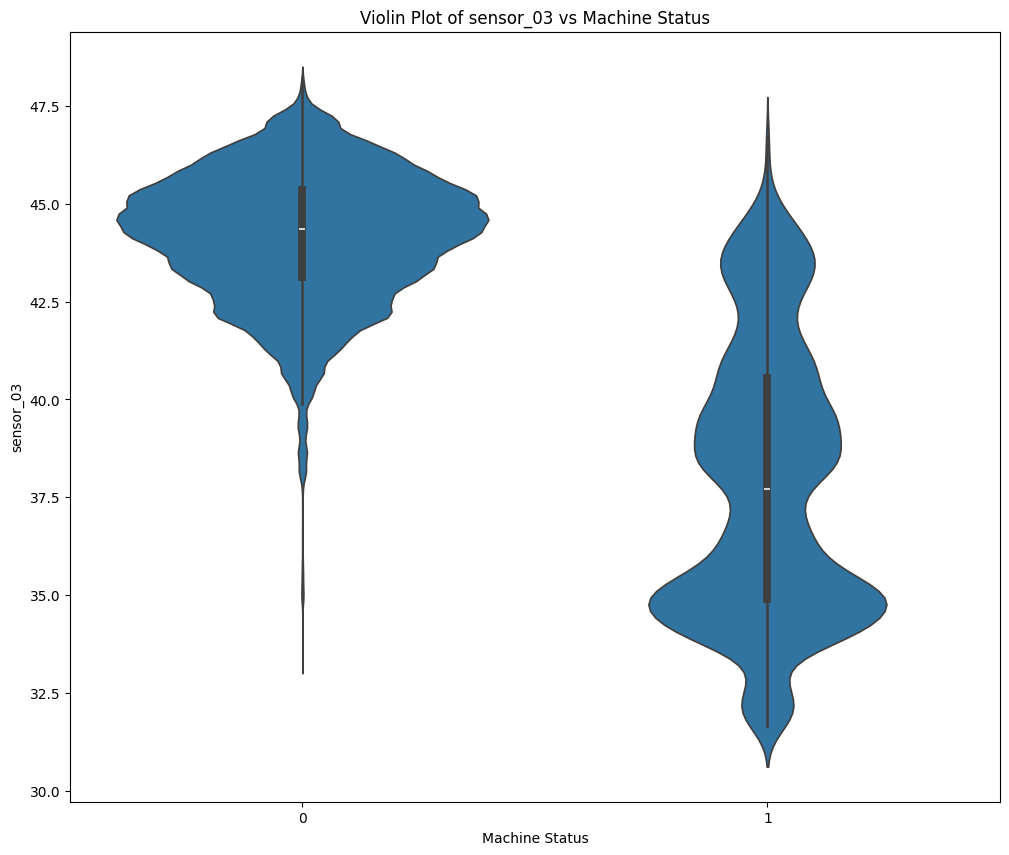

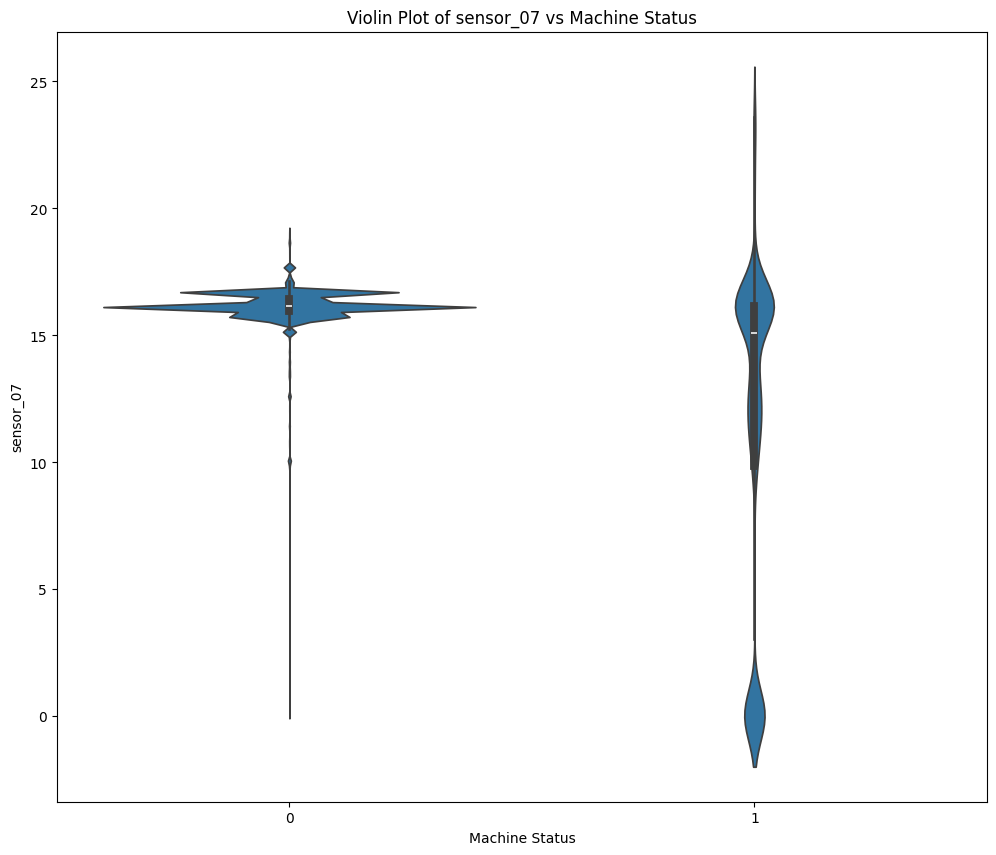

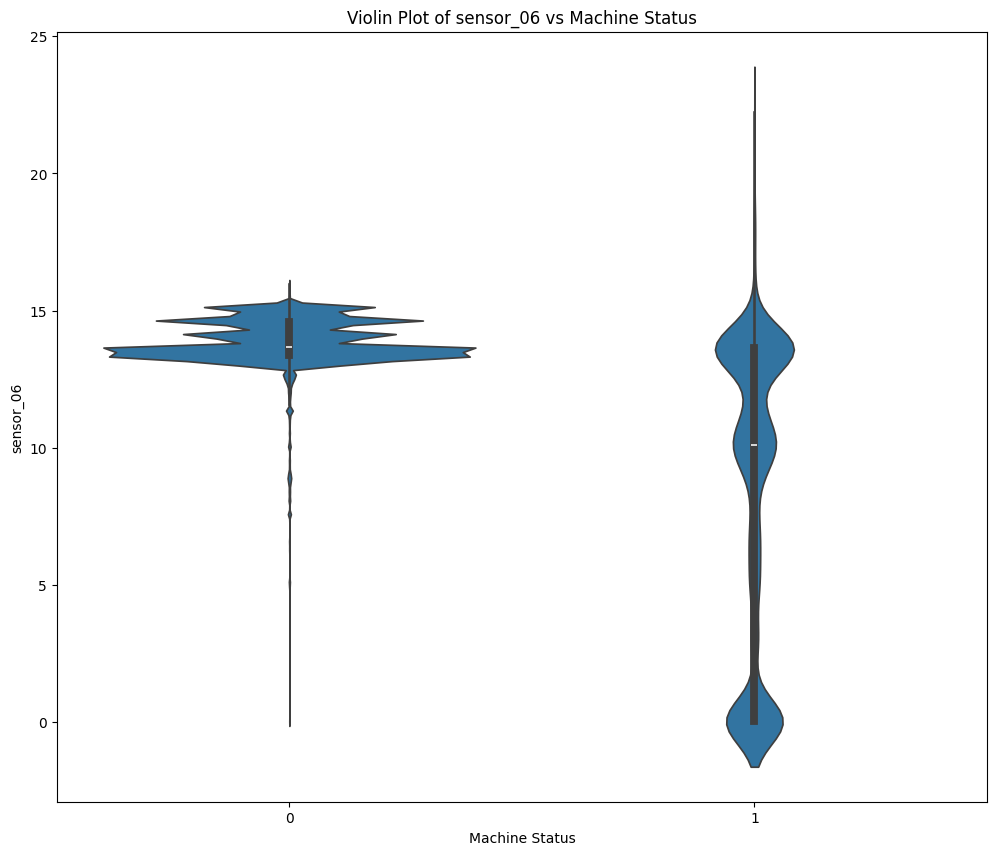

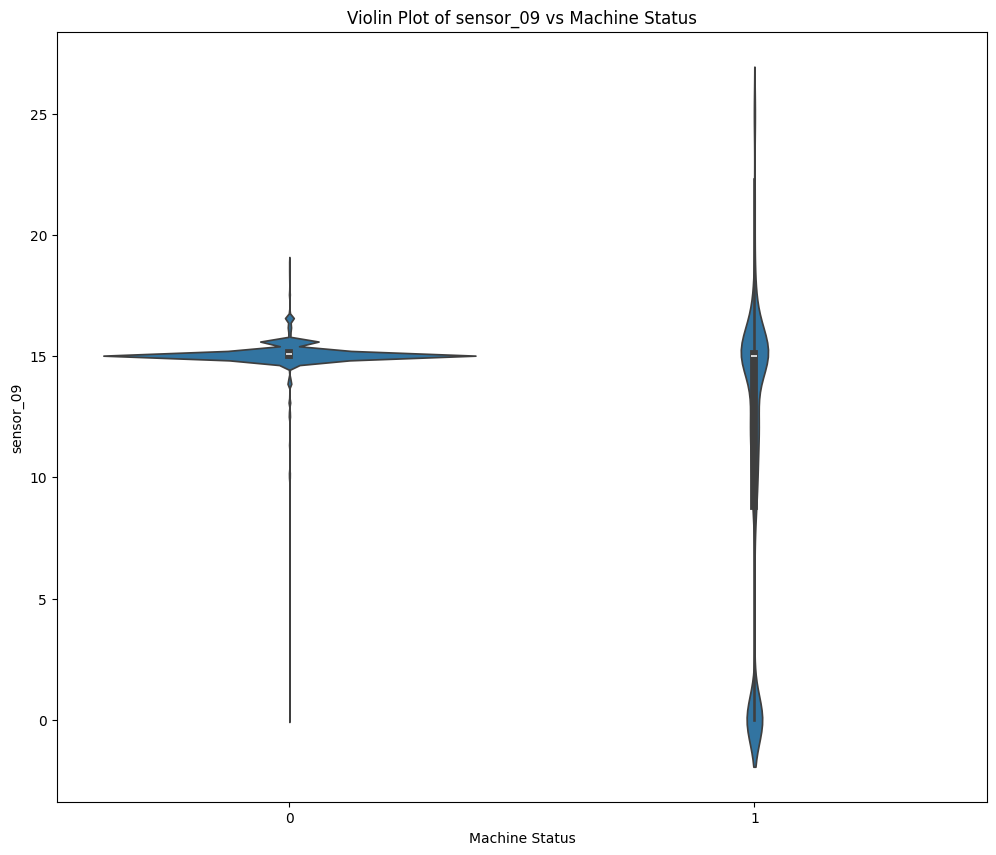

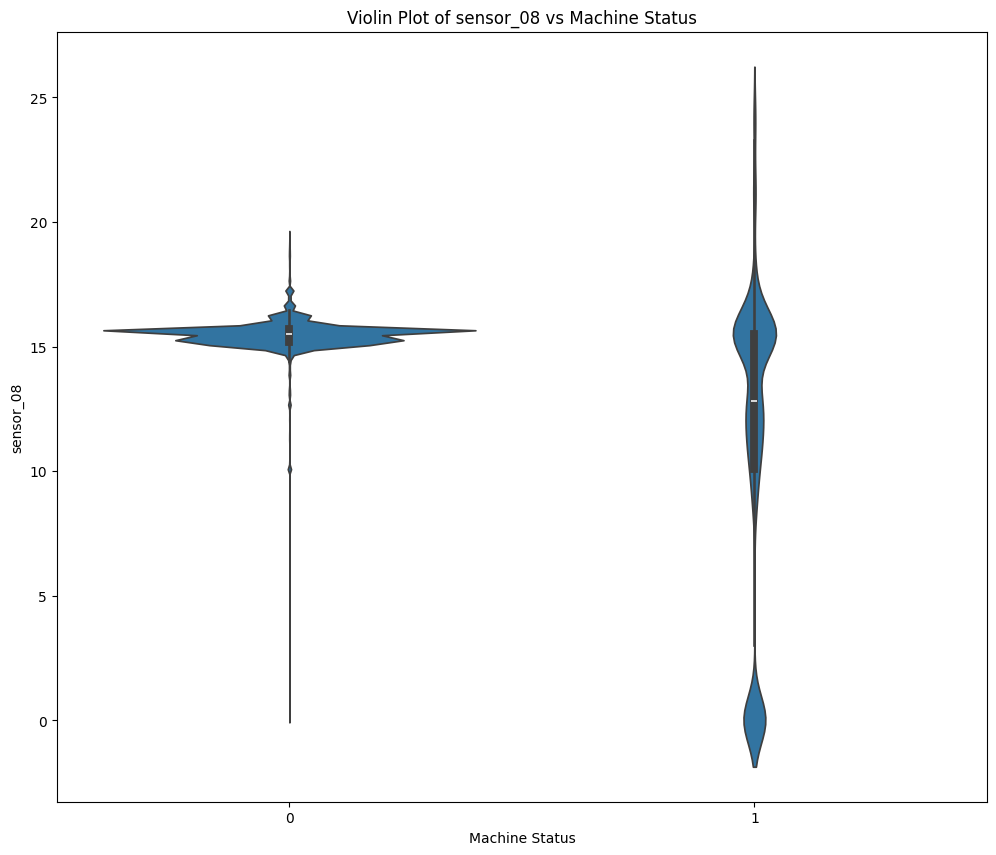

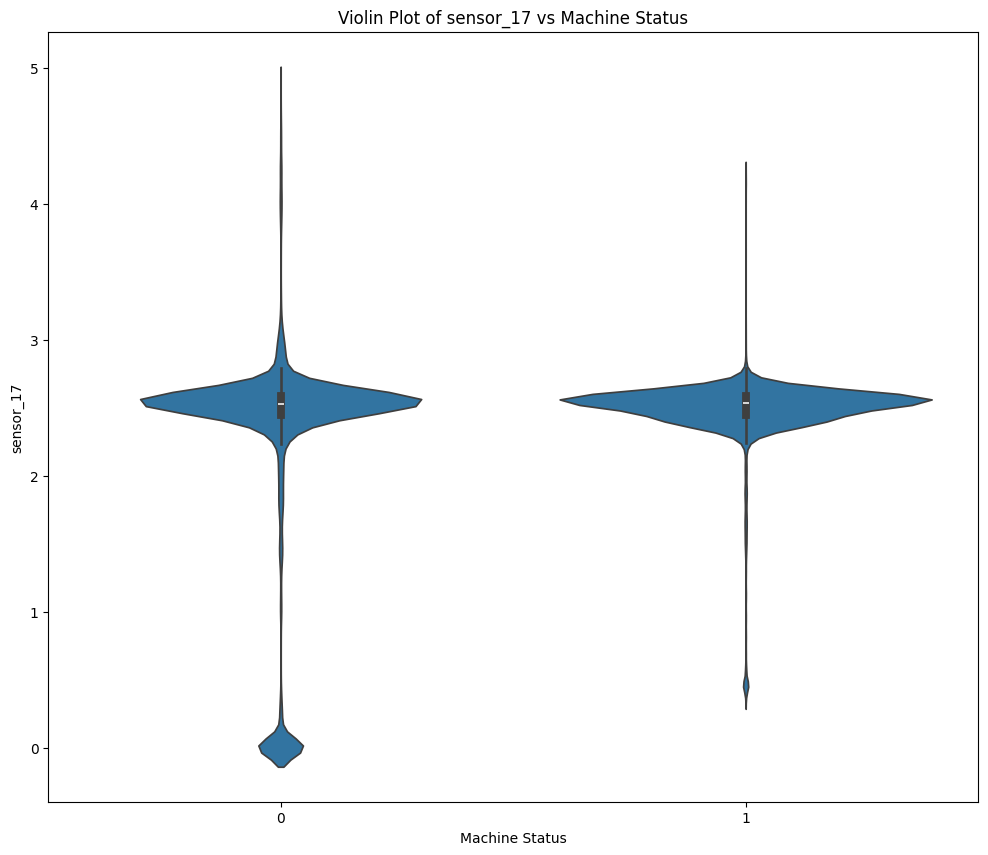

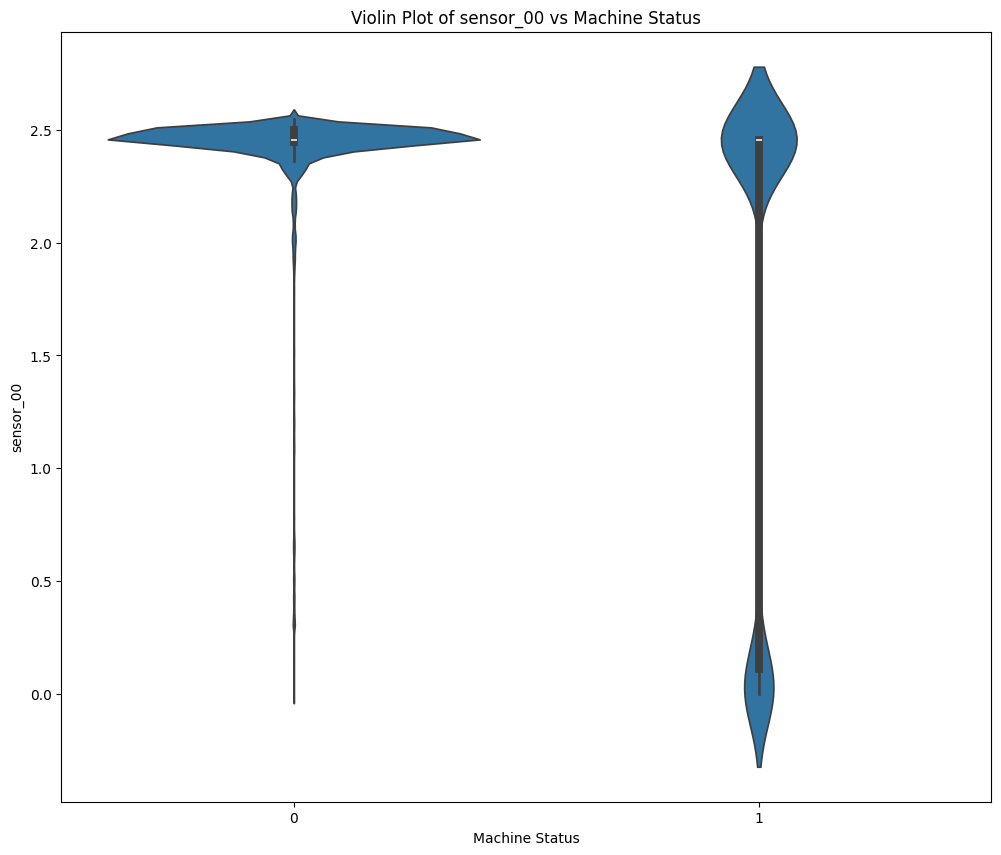

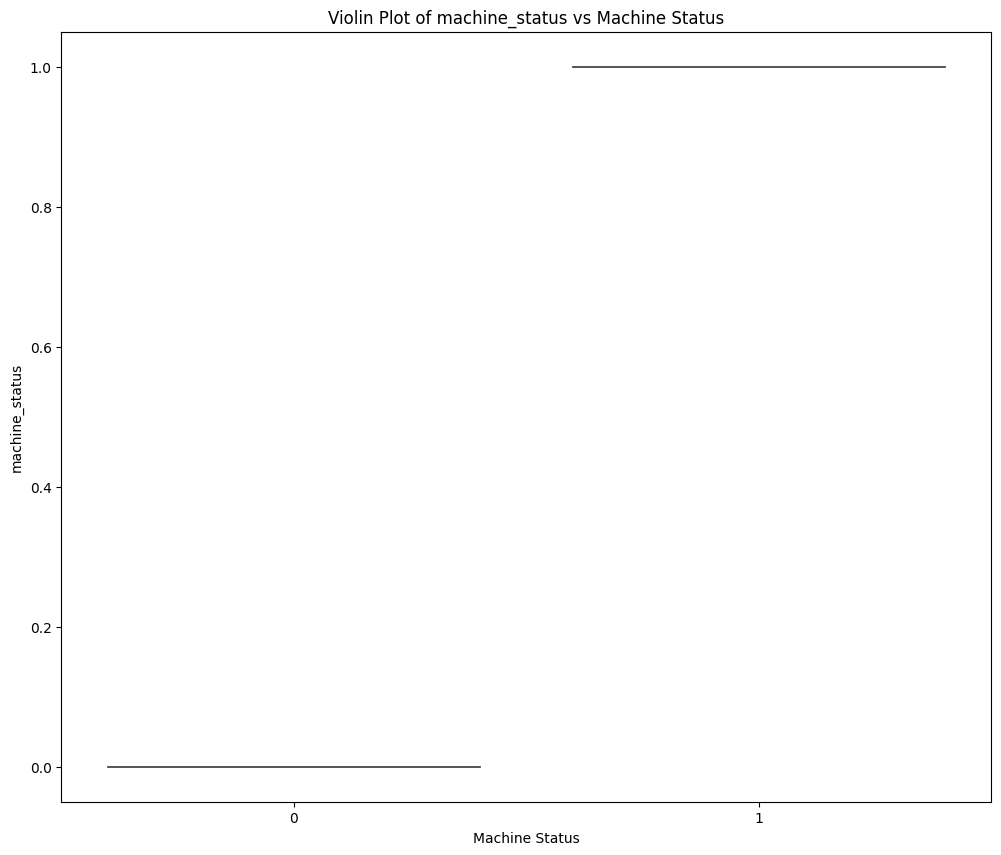

In [54]:
for sensor in selected_sensors:
    plt.figure(figsize=(12, 10))
    sns.violinplot(x=sensor_data['machine_status'], y=sensor_data[sensor])
    plt.title(f'Violin Plot of {sensor} vs Machine Status')
    plt.xlabel("Machine Status")
    plt.ylabel(sensor)
    plt.show()

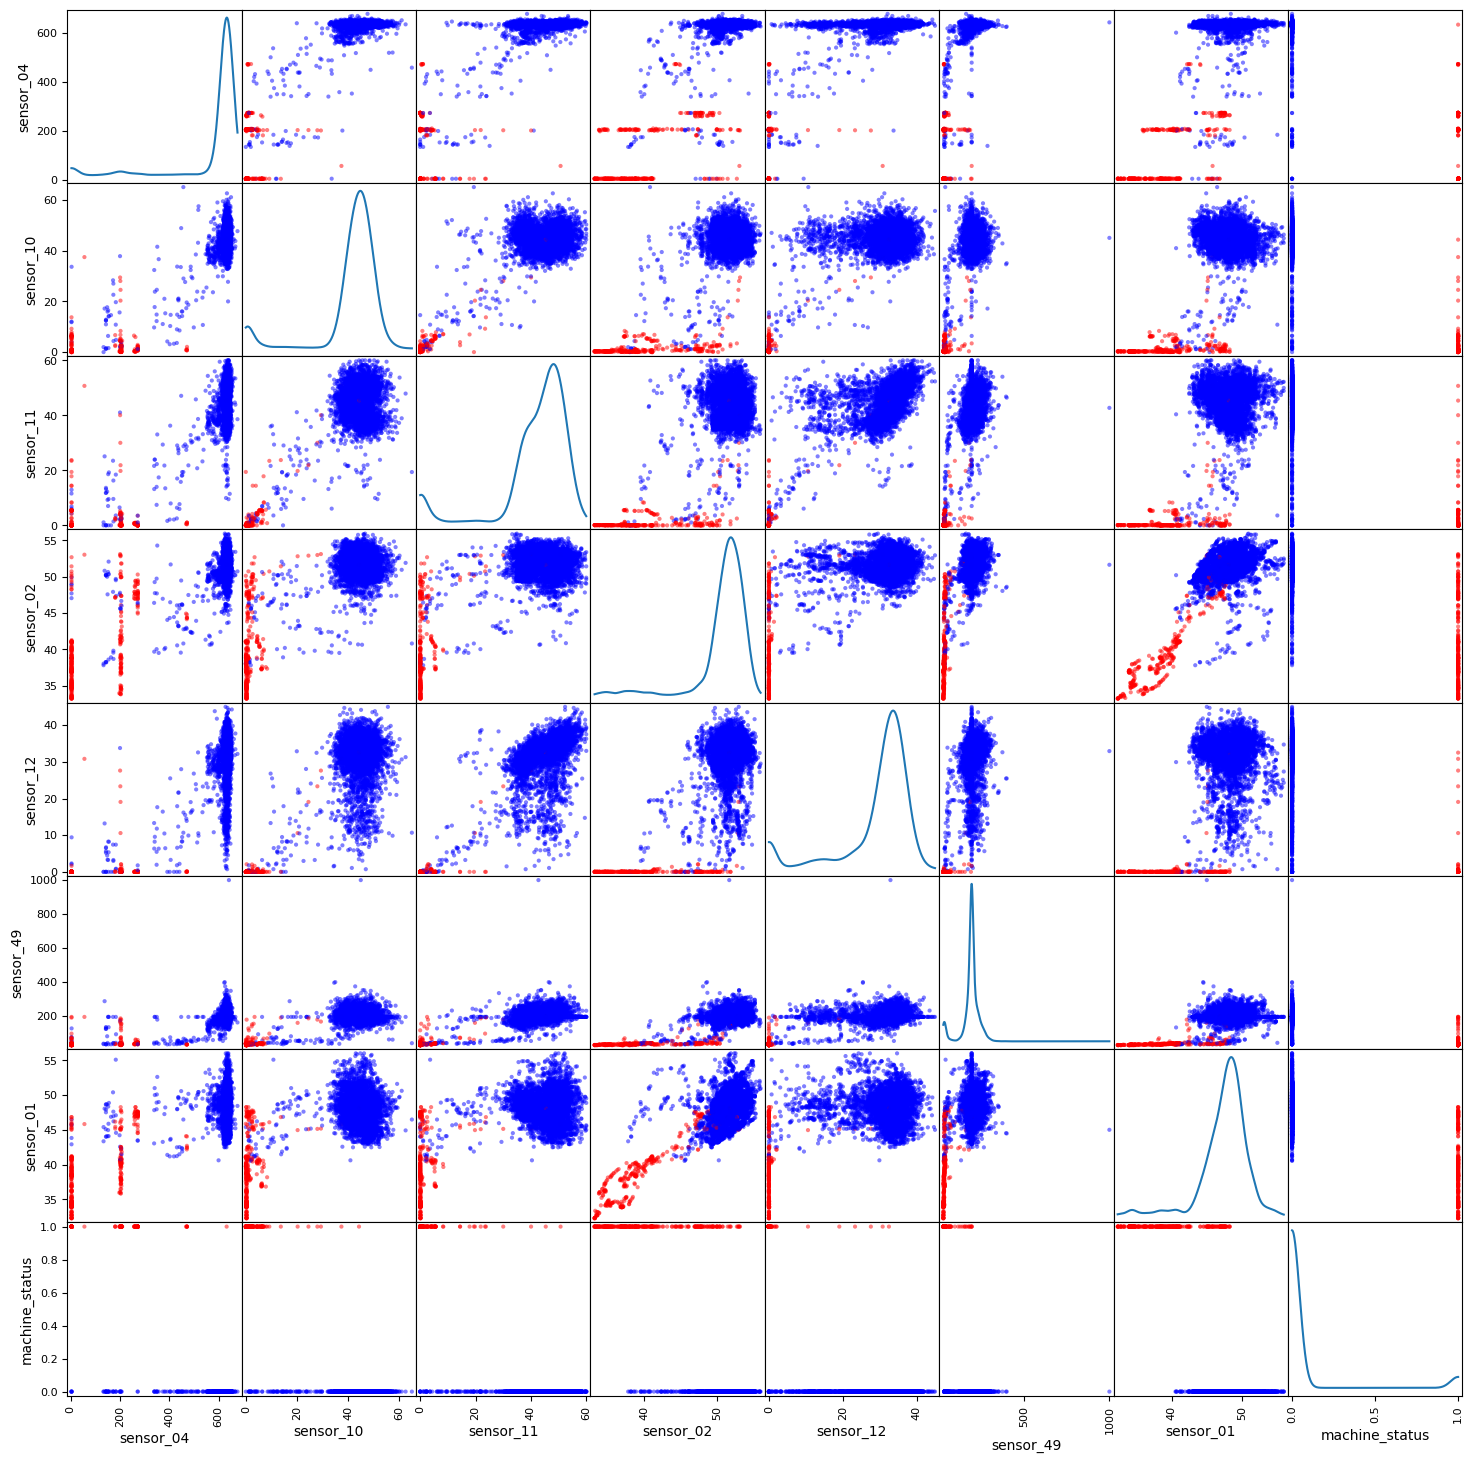

In [55]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
top_sensors = sensor_data.corr()['machine_status'].abs().sort_values(ascending=False).index[1:8]
sampled_data = sensor_data[top_sensors.tolist() + ['machine_status']].sample(n=5000, random_state=42)

# Create color map
colors = np.where(sampled_data['machine_status'] == 1, 'red', 'blue')  # Red for 1, blue for 0

# Generate Scatter Matrix with color
scatter_matrix(sampled_data, figsize=(18, 18), diagonal='kde', alpha=0.5, c=colors)
plt.show()

In [56]:

selected_sensors.remove('sensor_49')
#beacuse 49 and 04 highly correleated

In [64]:
sensor_data.drop("timestamp")
X = sensor_data.drop(columns=["machine_status"])
y = sensor_data["machine_status"]
#Dropping Timestamp also.
# sensor_data.drop("timestamp")


In [65]:
# Splitting the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Checking the shape of the splits
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Labels Shape:", y_train.shape)
print("Testing Labels Shape:", y_test.shape)

Training Features Shape: (176250, 52)
Testing Features Shape: (44063, 52)
Training Labels Shape: (176250,)
Testing Labels Shape: (44063,)


In [69]:
print(X_train.head())
print(X_test.head())

            ID  sensor_00  sensor_01  sensor_02  sensor_03   sensor_04  \
105979  105980   2.478183  48.828130  51.475693  42.708330  634.375000   
203004  203005   2.453588  50.737846  52.734371  45.442707  633.912048   
16675    16676   2.453588  53.211800  53.428820  47.135410  643.518600   
62804    62805   2.489989  47.135414  52.473960  43.446178  639.236100   
218272  218273   2.406366  48.914928  52.604160  46.050346  628.588000   

        sensor_05  sensor_06  sensor_07  sensor_08  ...  sensor_41  sensor_42  \
105979   73.86366   13.74421   15.95775   15.62500  ...  40.885414   45.31250   
203004   68.20253   15.08970   16.65220   16.10966  ...  34.114582   51.30208   
16675    74.42691   13.41146   16.75347   15.26331  ...  41.927082   47.13541   
62804    81.71547   13.49826   15.66117   15.26331  ...  33.593750   40.88541   
218272   73.34912   15.04630   16.47135   15.61777  ...  36.718750   42.18750   

        sensor_43  sensor_44  sensor_45  sensor_46   sensor_47  sens

In [70]:
# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [72]:
print(X_train)

[[-0.06686651  0.25316665  0.37544933 ...  0.25017591  0.10940195
   0.44625341]
 [ 1.45838278  0.19213094  0.9563404  ...  0.22000231  0.13124733
   0.04180097]
 [-1.47074039  0.19213094  1.70885925 ...  3.50888873  1.63858853
   0.6746178 ]
 ...
 [-0.48417409  0.19213094 -0.23184953 ... -0.3382032   0.30055003
  -0.16180069]
 [ 0.50306818  0.05052908 -0.69392313 ... -0.41363612  0.77022964
  -0.32688329]
 [ 0.48869994 -2.40553845 -1.18240036 ... -1.21322766 -2.71413186
  -1.53473873]]


In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#Training modelsss
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Ada Boost": AdaBoostClassifier(random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "LGBMR": LGBMClassifier(random_state=42),
    "XGBR": XGBClassifier(random_state=42),
    "SVM": SVC(probability=True),
    "Voting Classifier": VotingClassifier(
        estimators=[("rf", RandomForestClassifier()), ("gb", GradientBoostingClassifier()), ("xgb", XGBClassifier())], voting='soft'
    ),
    "Bagging Classifier": BaggingClassifier(random_state=42),
    "Stacking Classifier": StackingClassifier(
        estimators=[("rf", RandomForestClassifier()), ("gb", GradientBoostingClassifier()), ("xgb", XGBClassifier())]
    )
}

In [80]:
#for results
# Train and evaluate models
results = {}
best_model = None
best_score = 0

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }

    if roc_auc > best_score:
        best_score = roc_auc
        best_model = model

    print(f"{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}, ROC-AUC = {roc_auc:.4f}")



Logistic Regression: Accuracy = 0.9979, Precision = 0.9871, Recall = 0.9813, F1 = 0.9842, ROC-AUC = 0.9997
Decision Tree: Accuracy = 0.9999, Precision = 0.9993, Recall = 0.9993, F1 = 0.9993, ROC-AUC = 0.9996
Random Forest: Accuracy = 0.9999, Precision = 0.9993, Recall = 0.9990, F1 = 0.9991, ROC-AUC = 0.9998
Ada Boost: Accuracy = 0.9993, Precision = 0.9965, Recall = 0.9921, F1 = 0.9943, ROC-AUC = 1.0000
Gradient Boost: Accuracy = 0.9998, Precision = 0.9997, Recall = 0.9976, F1 = 0.9986, ROC-AUC = 0.9996


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 11582, number of negative: 164668
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12961
[LightGBM] [Info] Number of data points in the train set: 176250, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065713 -> initscore=-2.654479
[LightGBM] [Info] Start training from score -2.654479


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LGBMR: Accuracy = 0.9999, Precision = 0.9990, Recall = 0.9990, F1 = 0.9990, ROC-AUC = 1.0000
XGBR: Accuracy = 0.9999, Precision = 0.9993, Recall = 0.9993, F1 = 0.9993, ROC-AUC = 1.0000
SVM: Accuracy = 0.9997, Precision = 0.9997, Recall = 0.9962, F1 = 0.9979, ROC-AUC = 0.9996
Voting Classifier: Accuracy = 0.9999, Precision = 0.9993, Recall = 0.9993, F1 = 0.9993, ROC-AUC = 1.0000
Bagging Classifier: Accuracy = 0.9999, Precision = 0.9990, Recall = 0.9990, F1 = 0.9990, ROC-AUC = 0.9997
Stacking Classifier: Accuracy = 0.9999, Precision = 0.9993, Recall = 0.9990, F1 = 0.9991, ROC-AUC = 1.0000


In [83]:

# Create a DataFrame for results
results_df = pd.DataFrame(results).transpose()

# Print the results DataFrame
print("\nModel Performance Comparison:")
results_df





Model Performance Comparison:


Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regression  0.997935   0.987144  0.981347  0.984237  0.999656
Decision Tree        0.999909   0.999309  0.999309  0.999309  0.999630
Random Forest        0.999887   0.999309  0.998964  0.999136  0.999825
Ada Boost            0.999251   0.996530  0.992055  0.994288  0.999990
Gradient Boost       0.999818   0.999654  0.997582  0.998617  0.999645
LGBMR                0.999864   0.998964  0.998964  0.998964  1.000000
XGBR                 0.999909   0.999309  0.999309  0.999309  0.999998
SVM                  0.999728   0.999653  0.996200  0.997924  0.999632
Voting Classifier    0.999909   0.999309  0.999309  0.999309  0.999994
Bagging Classifier   0.999864   0.998964  0.998964  0.998964  0.999654
Stacking Classifier  0.999887   0.999309  0.998964  0.999136  0.999997

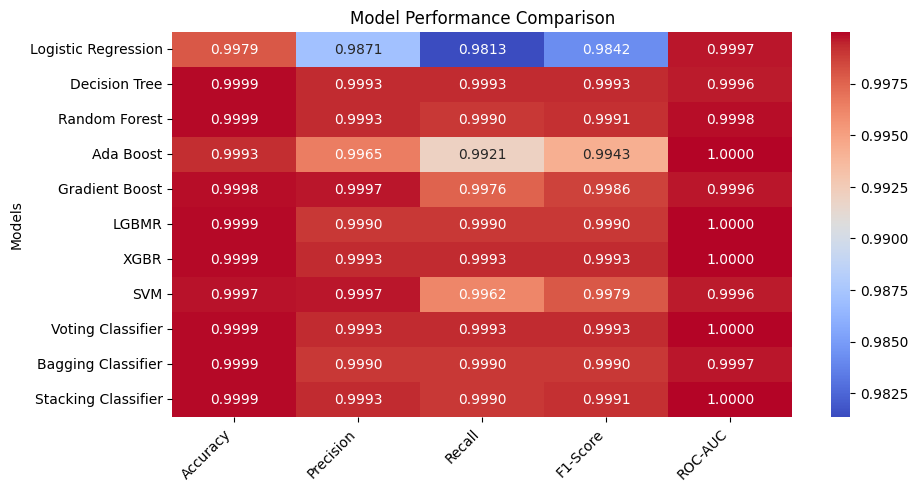

In [84]:
# Plot results
plt.figure(figsize=(10, 5))
sns.heatmap(results_df, annot=True, cmap="coolwarm", fmt=".4f")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Models")
plt.title("Model Performance Comparison")
plt.show()